# **Import Statements**

In [1]:
import sys
root = "C:\\Users\\saman\\OneDrive\\Documents\\GitHub\\Eyelid-Modeling\\" #laptop path
#root = "C:\\Users\\Samantha\\Documents\\GitHub\\Eyelid-Modeling\\" #desktop path
sys.path.append(root)

from utils.experiment_manager import Experiment
from models.EMG_RNN_CNN import EMG_RNN_CNN_Wrapper
from utils.data_management import Mat2TVT

import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

True

# **Data Reorganization** <br>


In [2]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = root + 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Run Experiments**

In [3]:
params = {
    't_win': np.arange(10,51,1, dtype = float),
    't_stride': np.arange(10, 51, 1, dtype = float),
    't_lookahead': np.arange(50, 101, 1, dtype = float),
    'win_mode': ['win_fft', 'win_rect'],
    'p_transform': np.linspace(0, 1, 100, dtype = float),
    'sigma': np.linspace(0, 5, 100, dtype = float),
    'p_mask': np.linspace(0, 0.5, 100, dtype = float),
    'batch_size': [4, 8, 16, 32, 64, 128],
    'learning_rate': np.linspace(1e-3, 1e-8, 500, dtype = float),
    'dropout': np.linspace(0, 1, 100, dtype = float),
    'RNN_hdim': [4, 8, 16, 32, 64, 128],
    'RNN_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'CNN_kernel': [3, 5]
}

experiment = Experiment()
model = EMG_RNN_CNN_Wrapper()
best_params = experiment(params, TVT_dict, model, n_trials = 250, epochs = 100, patience = 25, gcollect = False) 

print("Best Params:\n_________________________________________________________________________________________________________")
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

with open("best_params.pickle", "wb") as file:
    pickle.dump(best_params, file)

[I 2025-03-14 10:20:24,214] A new study created in memory with name: no-name-77da36da-f7a1-4d42-843b-e186b978c530


Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 12947.2%, Avg Marker Error: 192.6%, Avg loss: 1.462071 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2456.5%, Avg Marker Error: 122.8%, Avg loss: 1.084541 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 5019.5%, Avg Marker Error: 168.8%, Avg loss: 1.326797

[I 2025-03-14 10:25:13,873] Trial 11 finished with value: 0.9861733317375183 and parameters: {'t_win': np.float64(37.0), 't_stride': np.float64(45.0), 't_lookahead': np.float64(51.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6060606060606061), 'sigma': np.float64(2.676767676767677), 'p_mask': np.float64(0.19191919191919193), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.5353535353535354), 'RNN_hdim': 16, 'RNN_depth': 2, 'CNN_kernel': 5}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 1403.6%, Avg Marker Error: 96.2%, Avg loss: 0.988688 

Stopped early after epoch: 32
Done!
Validation Error: 
 Max Marker Error: 1002.5%, Avg Marker Error: 97.5%, Avg loss: 1.011708 

Epoch 31
-------------------------------
Validation Error: 
 Max Marker Error: 1774.3%, Avg Marker Error: 106.3%, Avg loss: 1.005087 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 749.1%, Avg Marker Error: 97.3%, Avg loss: 1.025045 

Epoch 13
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 711.7%, Avg Marker Error: 100.2%, Avg loss: 1.057508 

Epoch 67
-------------------------------
Validation Error: 
 Max Marker Error: 1207.1%, Avg Marker Error: 97.6%, Avg loss: 1.026712 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1590.5%, Avg Marker Error: 103.3%, Avg loss: 1.062715 

Epoch 6
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 10:27:09,432] Trial 1 finished with value: 1.008528709411621 and parameters: {'t_win': np.float64(34.0), 't_stride': np.float64(38.0), 't_lookahead': np.float64(73.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.17171717171717174), 'sigma': np.float64(0.5555555555555556), 'p_mask': np.float64(0.297979797979798), 'batch_size': 64, 'learning_rate': np.float64(0.0008436889378757514), 'dropout': np.float64(0.33333333333333337), 'RNN_hdim': 8, 'RNN_depth': 6, 'CNN_kernel': 5}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 1066.5%, Avg Marker Error: 97.5%, Avg loss: 1.011501 

Stopped early after epoch: 41
Done!
Validation Error: 
 Max Marker Error: 1193.5%, Avg Marker Error: 97.6%, Avg loss: 1.026742 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 662.7%, Avg Marker Error: 98.0%, Avg loss: 1.019196 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 635.5%, Avg Marker Error: 99.9%, Avg loss: 1.058335 

Epoch 94
-------------------------------
Validation Error: 
 Max Marker Error: 1410.7%, Avg Marker Error: 100.7%, Avg loss: 0.994440 

Epoch 35
-------------------------------
Validation Error: 
 Max Marker Error: 3674.1%, Avg Marker Error: 104.9%, Avg loss: 1.216351 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 781.6%, Avg Marker Error: 97.1%, Avg loss: 1.024055 

Epoch 18
-------------------------------
Validation Error: 
 Max Mark

[I 2025-03-14 10:27:39,865] Trial 15 finished with value: 1.0569558143615723 and parameters: {'t_win': np.float64(45.0), 't_stride': np.float64(47.0), 't_lookahead': np.float64(93.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.20202020202020204), 'sigma': np.float64(4.090909090909091), 'p_mask': np.float64(0.2373737373737374), 'batch_size': 128, 'learning_rate': np.float64(0.00013628118236472936), 'dropout': np.float64(0.8383838383838385), 'RNN_hdim': 64, 'RNN_depth': 3, 'CNN_kernel': 3}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 620.7%, Avg Marker Error: 99.9%, Avg loss: 1.058250 

Stopped early after epoch: 98
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1348.3%, Avg Marker Error: 99.9%, Avg loss: 0.994259 

Epoch 37
-------------------------------
Validation Error: 
 Max Marker Error: 1557.8%, Avg Marker Error: 99.0%, Avg loss: 1.036956 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 776.9%, Avg Marker Error: 97.1%, Avg loss: 1.023859 

Epoch 19
-------------------------------


[I 2025-03-14 10:27:43,952] Trial 3 finished with value: 1.0209711790084839 and parameters: {'t_win': np.float64(16.0), 't_stride': np.float64(44.0), 't_lookahead': np.float64(59.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.19191919191919193), 'sigma': np.float64(1.4141414141414141), 'p_mask': np.float64(0.015151515151515152), 'batch_size': 32, 'learning_rate': np.float64(0.0009018045891783567), 'dropout': np.float64(0.6363636363636365), 'RNN_hdim': 64, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 1183.9%, Avg Marker Error: 97.6%, Avg loss: 1.027118 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 4865.5%, Avg Marker Error: 143.0%, Avg loss: 1.148745 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 2843.3%, Avg Marker Error: 106.9%, Avg loss: 1.056472 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 744.8%, Avg Marker Error: 98.0%, Avg loss: 1.020758 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 3235.6%, Avg Marker Error: 100.9%, Avg loss: 1.062464 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 4862.7%, Avg Marker Error: 152.5%, Avg loss: 1.255308 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1312.2%, Avg Marker Error: 99.4%, Avg loss: 0.993830 

Epoch 38
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 10:33:23,639] Trial 6 finished with value: 1.0133634805679321 and parameters: {'t_win': np.float64(12.0), 't_stride': np.float64(29.0), 't_lookahead': np.float64(80.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.7272727272727273), 'sigma': np.float64(0.35353535353535354), 'p_mask': np.float64(0.16161616161616163), 'batch_size': 32, 'learning_rate': np.float64(0.0003707477755511021), 'dropout': np.float64(0.5050505050505051), 'RNN_hdim': 16, 'RNN_depth': 4, 'CNN_kernel': 5}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 979.2%, Avg Marker Error: 97.7%, Avg loss: 1.023346 

Stopped early after epoch: 31
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 699.6%, Avg Marker Error: 98.0%, Avg loss: 1.019190 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 827.9%, Avg Marker Error: 97.9%, Avg loss: 1.044094 

Epoch 57
-------------------------------


[I 2025-03-14 10:33:31,414] Trial 16 pruned. 


Validation Error: 
 Max Marker Error: 736.8%, Avg Marker Error: 98.3%, Avg loss: 1.043344 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 992.8%, Avg Marker Error: 96.5%, Avg loss: 1.001141 

Epoch 66
-------------------------------


[I 2025-03-14 10:33:33,592] Trial 10 pruned. 


Validation Error: 
 Max Marker Error: 462.3%, Avg Marker Error: 97.8%, Avg loss: 1.038539 



[I 2025-03-14 10:33:33,878] Trial 17 pruned. 


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2911.5%, Avg Marker Error: 107.7%, Avg loss: 1.048117 

Validation Error: 
 Max Marker Error: 826.4%, Avg Marker Error: 97.9%, Avg loss: 1.044293 

Epoch 58
-------------------------------
Validation Error: 
 Max Marker Error: 3935.6%, Avg Marker Error: 105.9%, Avg loss: 1.103972 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3761.0%, Avg Marker Error: 119.6%, Avg loss: 1.059541 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 822.8%, Avg Marker Error: 97.9%, Avg loss: 1.044417 

Epoch 59
-------------------------------


[I 2025-03-14 10:33:45,675] Trial 12 finished with value: 0.9932947158813477 and parameters: {'t_win': np.float64(31.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(63.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.393939393939394), 'sigma': np.float64(2.9797979797979797), 'p_mask': np.float64(0.3585858585858586), 'batch_size': 64, 'learning_rate': np.float64(0.0005230508617234469), 'dropout': np.float64(0.9797979797979799), 'RNN_hdim': 4, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 995.6%, Avg Marker Error: 96.5%, Avg loss: 1.001114 

Stopped early after epoch: 65
Done!


[I 2025-03-14 10:33:48,619] Trial 19 pruned. 


Validation Error: 
 Max Marker Error: 814.8%, Avg Marker Error: 97.9%, Avg loss: 1.044417 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1874.6%, Avg Marker Error: 111.5%, Avg loss: 1.039874 

Epoch 3
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 10:33:56,296] Trial 2 pruned. 


Validation Error: 
 Max Marker Error: 782.6%, Avg Marker Error: 97.1%, Avg loss: 1.079680 

Validation Error: 
 Max Marker Error: 1496.1%, Avg Marker Error: 106.1%, Avg loss: 1.034423 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 652.3%, Avg Marker Error: 98.0%, Avg loss: 1.018613 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1238.8%, Avg Marker Error: 102.5%, Avg loss: 1.038450 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 3216.1%, Avg Marker Error: 95.5%, Avg loss: 0.980110 

Epoch 27
-------------------------------


[I 2025-03-14 10:34:08,002] Trial 24 pruned. 


Validation Error: 
 Max Marker Error: 7190.9%, Avg Marker Error: 152.7%, Avg loss: 1.284608 



[I 2025-03-14 10:34:08,363] Trial 4 pruned. 


Validation Error: 
 Max Marker Error: 1129.6%, Avg Marker Error: 100.2%, Avg loss: 1.040734 

Validation Error: 
 Max Marker Error: 2145.2%, Avg Marker Error: 119.6%, Avg loss: 1.095243 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 984.4%, Avg Marker Error: 100.3%, Avg loss: 1.039155 

Epoch 6
-------------------------------


[I 2025-03-14 10:34:16,896] Trial 5 pruned. 


Validation Error: 
 Max Marker Error: 1116.9%, Avg Marker Error: 97.9%, Avg loss: 1.066353 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1301.6%, Avg Marker Error: 97.2%, Avg loss: 0.994677 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 800.3%, Avg Marker Error: 99.3%, Avg loss: 1.037715 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1683.1%, Avg Marker Error: 113.6%, Avg loss: 1.059327 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1249.6%, Avg Marker Error: 102.7%, Avg loss: 0.985170 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 771.6%, Avg Marker Error: 98.9%, Avg loss: 1.036950 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 661.3%, Avg Marker Error: 98.2%, Avg loss: 0.983420 

Epoch 3
-------------------------------


[I 2025-03-14 10:34:29,814] Trial 29 pruned. 


Validation Error: 
 Max Marker Error: 4937.2%, Avg Marker Error: 147.1%, Avg loss: 1.164512 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1531.1%, Avg Marker Error: 109.2%, Avg loss: 1.034997 

Epoch 4
-------------------------------


[I 2025-03-14 10:34:34,070] Trial 22 pruned. 


Validation Error: 
 Max Marker Error: 516.1%, Avg Marker Error: 100.3%, Avg loss: 0.982412 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 823.4%, Avg Marker Error: 98.8%, Avg loss: 1.040133 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 677.7%, Avg Marker Error: 98.2%, Avg loss: 0.983912 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 727.2%, Avg Marker Error: 98.0%, Avg loss: 1.022233 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 4364.9%, Avg Marker Error: 105.2%, Avg loss: 1.088353 

Epoch 28
-------------------------------


[I 2025-03-14 10:34:39,690] Trial 30 pruned. 


Validation Error: 
 Max Marker Error: 8075.3%, Avg Marker Error: 163.9%, Avg loss: 1.285875 

Epoch 1
-------------------------------


[I 2025-03-14 10:34:43,750] Trial 13 pruned. 


Validation Error: 
 Max Marker Error: 1424.8%, Avg Marker Error: 96.5%, Avg loss: 1.036146 



[I 2025-03-14 10:34:44,004] Trial 31 pruned. 


Validation Error: 
 Max Marker Error: 2712.6%, Avg Marker Error: 131.2%, Avg loss: 1.131713 

Validation Error: 
 Max Marker Error: 509.2%, Avg Marker Error: 98.7%, Avg loss: 1.069225 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 758.8%, Avg Marker Error: 97.5%, Avg loss: 0.989595 

Epoch 5
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1405.2%, Avg Marker Error: 105.7%, Avg loss: 1.015394 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 314.5%, Avg Marker Error: 100.1%, Avg loss: 0.982159 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1401.6%, Avg Marker Error: 97.4%, Avg loss: 1.052854 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 920.2%, Avg Marker Error: 101.3%, Avg loss: 1.011744 

Epoch 2
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 10:35:41,416] Trial 23 pruned. 


Validation Error: 
 Max Marker Error: 6875.4%, Avg Marker Error: 144.6%, Avg loss: 1.211841 

Validation Error: 
 Max Marker Error: 4007.6%, Avg Marker Error: 100.9%, Avg loss: 1.015138 

Epoch 30
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 204.5%, Avg Marker Error: 100.0%, Avg loss: 1.011463 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 621.8%, Avg Marker Error: 98.0%, Avg loss: 1.019173 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 976.9%, Avg Marker Error: 100.2%, Avg loss: 0.985533 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 312.9%, Avg Marker Error: 99.4%, Avg loss: 0.983888 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 741.4%, Avg Marker Error: 97.1%, Avg loss: 0.993132 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 688.5%, Avg Marker Error: 97

[I 2025-03-14 10:35:51,909] Trial 35 pruned. 


Validation Error: 
 Max Marker Error: 13241.7%, Avg Marker Error: 182.0%, Avg loss: 1.428993 

Validation Error: 
 Max Marker Error: 654.2%, Avg Marker Error: 100.8%, Avg loss: 0.985496 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1209.1%, Avg Marker Error: 99.5%, Avg loss: 1.048376 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 731.9%, Avg Marker Error: 97.2%, Avg loss: 0.990699 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 944.0%, Avg Marker Error: 100.0%, Avg loss: 0.985346 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 351.8%, Avg Marker Error: 99.4%, Avg loss: 0.984345 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1330.4%, Avg Marker Error: 95.7%, Avg loss: 1.051875 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 156.2%, Avg Marker Error: 10

[I 2025-03-14 10:36:20,036] Trial 0 finished with value: 1.0122138261795044 and parameters: {'t_win': np.float64(46.0), 't_stride': np.float64(20.0), 't_lookahead': np.float64(89.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.14141414141414144), 'sigma': np.float64(0.050505050505050504), 'p_mask': np.float64(0.2070707070707071), 'batch_size': 32, 'learning_rate': np.float64(0.00046293122244488974), 'dropout': np.float64(0.04040404040404041), 'RNN_hdim': 128, 'RNN_depth': 9, 'CNN_kernel': 3}. Best is trial 11 with value: 0.9861733317375183.


Validation Error: 
 Max Marker Error: 889.9%, Avg Marker Error: 98.1%, Avg loss: 1.024037 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 3979.1%, Avg Marker Error: 114.2%, Avg loss: 1.042492 

Epoch 3
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 710.3%, Avg Marker Error: 97.9%, Avg loss: 0.998714 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 852.1%, Avg Marker Error: 99.3%, Avg loss: 0.986287 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 758.0%, Avg Marker Error: 97.1%, Avg loss: 0.991494 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 424.6%, Avg Marker Error: 99.3%, Avg loss: 0.985140 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 103.9%, Avg Marker Error: 100.0%, Avg loss: 1.011476 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Er

[I 2025-03-14 10:36:38,294] Trial 25 pruned. 


Validation Error: 
 Max Marker Error: 541.4%, Avg Marker Error: 98.5%, Avg loss: 1.069790 

Validation Error: 
 Max Marker Error: 753.8%, Avg Marker Error: 97.9%, Avg loss: 1.001380 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 661.4%, Avg Marker Error: 97.1%, Avg loss: 0.989311 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 108.6%, Avg Marker Error: 100.0%, Avg loss: 1.011480 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 3810.3%, Avg Marker Error: 99.5%, Avg loss: 1.006384 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 2639.2%, Avg Marker Error: 106.2%, Avg loss: 1.013385 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 802.5%, Avg Marker Error: 98.8%, Avg loss: 0.989395 

Epoch 15
-------------------------------


[I 2025-03-14 10:36:49,684] Trial 38 pruned. 


Validation Error: 
 Max Marker Error: 14667.0%, Avg Marker Error: 207.9%, Avg loss: 1.634612 

Validation Error: 
 Max Marker Error: 488.5%, Avg Marker Error: 99.2%, Avg loss: 0.985891 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 122.2%, Avg Marker Error: 100.0%, Avg loss: 1.011492 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 738.4%, Avg Marker Error: 97.0%, Avg loss: 0.992719 

Epoch 19
-------------------------------


[I 2025-03-14 10:36:52,264] Trial 37 pruned. 


Validation Error: 
 Max Marker Error: 2238.1%, Avg Marker Error: 127.3%, Avg loss: 1.080771 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 692.9%, Avg Marker Error: 97.9%, Avg loss: 0.998260 

Epoch 9
-------------------------------


[I 2025-03-14 10:36:58,341] Trial 21 pruned. 


Validation Error: 
 Max Marker Error: 1891.6%, Avg Marker Error: 98.5%, Avg loss: 1.077615 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 153.0%, Avg Marker Error: 100.0%, Avg loss: 1.011514 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 3070.4%, Avg Marker Error: 129.6%, Avg loss: 1.120826 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2223.9%, Avg Marker Error: 103.7%, Avg loss: 1.006265 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 801.7%, Avg Marker Error: 98.5%, Avg loss: 0.991148 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 673.8%, Avg Marker Error: 97.2%, Avg loss: 0.987973 

Epoch 20
-------------------------------


[I 2025-03-14 10:37:02,826] Trial 40 pruned. 


Validation Error: 
 Max Marker Error: 5736.0%, Avg Marker Error: 161.2%, Avg loss: 1.238623 

Validation Error: 
 Max Marker Error: 528.8%, Avg Marker Error: 99.1%, Avg loss: 0.986414 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 260.7%, Avg Marker Error: 100.1%, Avg loss: 0.983178 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 171.7%, Avg Marker Error: 100.0%, Avg loss: 1.011528 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 726.5%, Avg Marker Error: 96.9%, Avg loss: 0.992273 

Epoch 21
-------------------------------


[I 2025-03-14 10:37:11,723] Trial 39 pruned. 


Validation Error: 
 Max Marker Error: 2447.4%, Avg Marker Error: 120.5%, Avg loss: 1.080793 

Validation Error: 
 Max Marker Error: 699.0%, Avg Marker Error: 97.9%, Avg loss: 0.999273 

Epoch 10
-------------------------------


[I 2025-03-14 10:37:12,483] Trial 42 pruned. 


Validation Error: 
 Max Marker Error: 18340.9%, Avg Marker Error: 186.3%, Avg loss: 1.588935 



[I 2025-03-14 10:37:13,189] Trial 41 pruned. 


Validation Error: 
 Max Marker Error: 6480.4%, Avg Marker Error: 164.2%, Avg loss: 1.255352 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 766.0%, Avg Marker Error: 98.2%, Avg loss: 0.993982 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 2091.8%, Avg Marker Error: 101.0%, Avg loss: 1.001960 

Epoch 7
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 561.8%, Avg Marker Error: 99.1%, Avg loss: 0.986946 

Epoch 16
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 204.8%, Avg Marker Error: 100.0%, Avg loss: 1.011551 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 3625.1%, Avg Marker Error: 95.9%, Avg loss: 0.973485 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 725.4%, Avg Marker Error: 97.0%, Avg loss: 0.992263 

Epoch 22
-----------------

[I 2025-03-14 10:37:27,538] Trial 43 pruned. 


Validation Error: 
 Max Marker Error: 2908.2%, Avg Marker Error: 141.7%, Avg loss: 1.159643 

Validation Error: 
 Max Marker Error: 231.8%, Avg Marker Error: 100.0%, Avg loss: 1.011572 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1976.3%, Avg Marker Error: 99.9%, Avg loss: 1.001167 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 557.6%, Avg Marker Error: 99.1%, Avg loss: 0.986769 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 666.4%, Avg Marker Error: 97.9%, Avg loss: 0.998313 

Epoch 11
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 754.8%, Avg Marker Error: 97.1%, Avg loss: 0.990045 

Epoch 23
-------------------------------


[I 2025-03-14 10:37:35,781] Trial 44 pruned. 


Validation Error: 
 Max Marker Error: 14226.2%, Avg Marker Error: 233.6%, Avg loss: 1.951617 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 279.6%, Avg Marker Error: 99.9%, Avg loss: 1.011645 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 667.4%, Avg Marker Error: 97.1%, Avg loss: 0.989881 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 756.5%, Avg Marker Error: 98.0%, Avg loss: 0.996157 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 225.6%, Avg Marker Error: 100.1%, Avg loss: 0.983078 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 561.0%, Avg Marker Error: 99.1%, Avg loss: 0.986856 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1899.7%, Avg Marker Error: 99.5%, Avg loss: 1.001035 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 341.4%, Avg Marker Error: 99.

[I 2025-03-14 10:38:17,306] Trial 45 pruned. 


Validation Error: 
 Max Marker Error: 3242.6%, Avg Marker Error: 116.4%, Avg loss: 1.078952 

Validation Error: 
 Max Marker Error: 894.3%, Avg Marker Error: 97.9%, Avg loss: 0.998564 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 203.5%, Avg Marker Error: 100.1%, Avg loss: 0.983046 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 616.1%, Avg Marker Error: 97.9%, Avg loss: 0.996013 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 297.0%, Avg Marker Error: 99.5%, Avg loss: 1.012820 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 651.8%, Avg Marker Error: 99.1%, Avg loss: 0.988411 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1654.8%, Avg Marker Error: 98.7%, Avg loss: 0.999860 

Epoch 12
-------------------------------


[I 2025-03-14 10:38:25,732] Trial 27 finished with value: 0.9834202527999878 and parameters: {'t_win': np.float64(31.0), 't_stride': np.float64(45.0), 't_lookahead': np.float64(63.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6060606060606061), 'sigma': np.float64(2.676767676767677), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.0005230508617234469), 'dropout': np.float64(0.5353535353535354), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 27 with value: 0.9834202527999878.


Validation Error: 
 Max Marker Error: 700.3%, Avg Marker Error: 97.1%, Avg loss: 0.990869 

Stopped early after epoch: 27
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3235.7%, Avg Marker Error: 95.3%, Avg loss: 0.956070 

Epoch 35
-------------------------------
Validation Error: 
 Max Marker Error: 300.4%, Avg Marker Error: 99.5%, Avg loss: 1.012817 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 999.8%, Avg Marker Error: 99.1%, Avg loss: 1.048417 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 827.0%, Avg Marker Error: 97.8%, Avg loss: 0.997930 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 607.0%, Avg Marker Error: 99.1%, Avg loss: 0.987707 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 690.7%, Avg Marker Error: 97.9%, Avg loss: 0.998757 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Err

[I 2025-03-14 10:38:36,668] Trial 8 pruned. 


Validation Error: 
 Max Marker Error: 297.4%, Avg Marker Error: 99.5%, Avg loss: 1.012812 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 2520.2%, Avg Marker Error: 98.0%, Avg loss: 1.067246 



[I 2025-03-14 10:38:37,532] Trial 47 pruned. 


Validation Error: 
 Max Marker Error: 1036.8%, Avg Marker Error: 99.3%, Avg loss: 1.042266 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 450.0%, Avg Marker Error: 99.0%, Avg loss: 1.017523 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 688.7%, Avg Marker Error: 97.0%, Avg loss: 1.031449 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 841.1%, Avg Marker Error: 97.8%, Avg loss: 0.997747 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 348.0%, Avg Marker Error: 99.2%, Avg loss: 1.014270 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 654.4%, Avg Marker Error: 99.1%, Avg loss: 0.988472 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 530.8%, Avg Marker Error: 99.4%, Avg loss: 1.010195 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker E

[I 2025-03-14 10:39:19,454] Trial 33 finished with value: 1.011459231376648 and parameters: {'t_win': np.float64(37.0), 't_stride': np.float64(48.0), 't_lookahead': np.float64(79.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6060606060606061), 'sigma': np.float64(0.9090909090909091), 'p_mask': np.float64(0.06060606060606061), 'batch_size': 64, 'learning_rate': np.float64(0.0008917846492985972), 'dropout': np.float64(0.888888888888889), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 27 with value: 0.9834202527999878.


Validation Error: 
 Max Marker Error: 383.1%, Avg Marker Error: 99.1%, Avg loss: 1.015283 

Stopped early after epoch: 31
Done!
Validation Error: 
 Max Marker Error: 948.4%, Avg Marker Error: 97.8%, Avg loss: 0.998942 

Epoch 27
-------------------------------


[I 2025-03-14 10:39:21,436] Trial 9 pruned. 


Validation Error: 
 Max Marker Error: 1731.3%, Avg Marker Error: 96.3%, Avg loss: 1.076606 

Validation Error: 
 Max Marker Error: 596.4%, Avg Marker Error: 99.1%, Avg loss: 0.987650 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 648.4%, Avg Marker Error: 97.9%, Avg loss: 0.997503 

Epoch 18
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 176.5%, Avg Marker Error: 100.0%, Avg loss: 0.983017 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 633.8%, Avg Marker Error: 97.7%, Avg loss: 1.019324 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1366.2%, Avg Marker Error: 98.0%, Avg loss: 0.998999 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 2545.6%, Avg Marker Error: 98.1%, Avg loss: 1.045600 

Epoch 37
-------------------------------
Validation Error: 
 Max Mark

[I 2025-03-14 10:39:46,827] Trial 50 pruned. 


Validation Error: 
 Max Marker Error: 1376.8%, Avg Marker Error: 99.2%, Avg loss: 1.029304 

Validation Error: 
 Max Marker Error: 672.2%, Avg Marker Error: 99.0%, Avg loss: 0.988847 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 684.4%, Avg Marker Error: 97.5%, Avg loss: 1.022441 

Epoch 5
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 10:39:54,406] Trial 46 pruned. 


Validation Error: 
 Max Marker Error: 703.5%, Avg Marker Error: 97.0%, Avg loss: 1.030438 

Validation Error: 
 Max Marker Error: 1242.8%, Avg Marker Error: 97.8%, Avg loss: 0.998991 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 686.0%, Avg Marker Error: 97.9%, Avg loss: 0.999133 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 979.1%, Avg Marker Error: 97.7%, Avg loss: 1.000815 

Epoch 30
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 653.6%, Avg Marker Error: 99.0%, Avg loss: 0.988571 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 169.1%, Avg Marker Error: 100.0%, Avg loss: 0.983009 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 3488.2%, Avg Marker Error: 97.

[I 2025-03-14 10:40:16,770] Trial 51 pruned. 


Validation Error: 
 Max Marker Error: 97399040.0%, Avg Marker Error: 19850.2%, Avg loss: 76905328.000000 

Epoch 1
-------------------------------


[I 2025-03-14 10:40:20,079] Trial 55 pruned. 


Validation Error: 
 Max Marker Error: 3415.7%, Avg Marker Error: 164.7%, Avg loss: 1.331884 

Validation Error: 
 Max Marker Error: 994.9%, Avg Marker Error: 97.7%, Avg loss: 1.000265 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 1201.2%, Avg Marker Error: 97.6%, Avg loss: 0.998372 

Epoch 21
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 10:40:23,582] Trial 28 finished with value: 0.982055127620697 and parameters: {'t_win': np.float64(31.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.26262626262626265), 'sigma': np.float64(2.676767676767677), 'p_mask': np.float64(0.196969696969697), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.9393939393939394), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 544.4%, Avg Marker Error: 99.1%, Avg loss: 0.986896 

Stopped early after epoch: 29
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 705.6%, Avg Marker Error: 97.9%, Avg loss: 0.999572 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 555.9%, Avg Marker Error: 97.6%, Avg loss: 1.019393 

Epoch 7
-------------------------------


[I 2025-03-14 10:40:29,654] Trial 56 pruned. 


Validation Error: 
 Max Marker Error: 3642.3%, Avg Marker Error: 128.8%, Avg loss: 1.085394 



[I 2025-03-14 10:40:31,200] Trial 53 pruned. 


Validation Error: 
 Max Marker Error: 1946.3%, Avg Marker Error: 112.0%, Avg loss: 1.058969 

Epoch 1
-------------------------------


[I 2025-03-14 10:40:32,307] Trial 57 pruned. 


Validation Error: 
 Max Marker Error: 5683.6%, Avg Marker Error: 130.0%, Avg loss: 1.144381 

Validation Error: 
 Max Marker Error: 935.7%, Avg Marker Error: 97.7%, Avg loss: 1.000303 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 1205.5%, Avg Marker Error: 97.6%, Avg loss: 0.998335 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 4131.6%, Avg Marker Error: 101.4%, Avg loss: 1.040105 

Epoch 39
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 160.6%, Avg Marker Error: 100.0%, Avg loss: 0.983002 

Epoch 11
-------------------------------


[I 2025-03-14 10:40:42,205] Trial 58 pruned. 


Validation Error: 
 Max Marker Error: 7601.1%, Avg Marker Error: 146.2%, Avg loss: 1.191628 



[I 2025-03-14 10:40:43,122] Trial 59 pruned. 


Validation Error: 
 Max Marker Error: 9727.9%, Avg Marker Error: 170.8%, Avg loss: 1.499075 

Validation Error: 
 Max Marker Error: 656.0%, Avg Marker Error: 97.9%, Avg loss: 0.997343 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 893.1%, Avg Marker Error: 97.7%, Avg loss: 0.999927 

Epoch 34
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1211.1%, Avg Marker Error: 97.6%, Avg loss: 0.998208 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 644.3%, Avg Marker Error: 97.4%, Avg loss: 1.025940 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 924.7%, Avg Marker Error: 97.6%, Avg loss: 1.001046 

Epoch 35
-------------------------------
Validation Error: 
 Max Mark

[I 2025-03-14 10:40:59,000] Trial 52 pruned. 


Validation Error: 
 Max Marker Error: 1043.1%, Avg Marker Error: 99.1%, Avg loss: 1.060871 



[I 2025-03-14 10:40:59,285] Trial 20 pruned. 


Validation Error: 
 Max Marker Error: 1445.3%, Avg Marker Error: 98.0%, Avg loss: 1.058542 

Validation Error: 
 Max Marker Error: 1208.1%, Avg Marker Error: 97.5%, Avg loss: 0.998004 

Epoch 24
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 4412.8%, Avg Marker Error: 111.1%, Avg loss: 1.193766 

Epoch 40
-------------------------------
Validation Error: 
 Max Marker Error: 851.1%, Avg Marker Error: 97.7%, Avg loss: 1.000543 

Epoch 36
-------------------------------
Validation Error: 
 Max Marker Error: 624.3%, Avg Marker Error: 97.4%, Avg loss: 1.024844 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 151.7%, Avg Marker Error: 100.0%, Avg loss: 0.982994 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1217.2%, Avg Marker Error: 97.5%, Avg loss: 0.998087 

Epoch 25
-------------------------------
Validation Error: 
 Max M

[I 2025-03-14 10:41:15,404] Trial 14 pruned. 


Validation Error: 
 Max Marker Error: 1591.3%, Avg Marker Error: 95.8%, Avg loss: 1.060876 

Epoch 1
-------------------------------


[I 2025-03-14 10:41:20,501] Trial 26 finished with value: 0.9853461980819702 and parameters: {'t_win': np.float64(31.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.32323232323232326), 'sigma': np.float64(1.6161616161616161), 'p_mask': np.float64(0.3585858585858586), 'batch_size': 64, 'learning_rate': np.float64(0.0005551146693386774), 'dropout': np.float64(0.9797979797979799), 'RNN_hdim': 32, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 885.2%, Avg Marker Error: 97.6%, Avg loss: 1.000707 

Stopped early after epoch: 35
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1257.6%, Avg Marker Error: 100.7%, Avg loss: 1.031661 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1233.2%, Avg Marker Error: 97.5%, Avg loss: 0.998397 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 2820.2%, Avg Marker Error: 108.7%, Avg loss: 1.029026 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 560.9%, Avg Marker Error: 97.4%, Avg loss: 1.022640 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 644.7%, Avg Marker Error: 97.9%, Avg loss: 0.997228 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 10:42:03,190] Trial 34 finished with value: 0.9956899881362915 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(99.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.9292929292929294), 'sigma': np.float64(0.15151515151515152), 'p_mask': np.float64(0.2575757575757576), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 701.7%, Avg Marker Error: 97.9%, Avg loss: 0.999302 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1407.8%, Avg Marker Error: 101.3%, Avg loss: 0.997916 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1210.7%, Avg Marker Error: 97.5%, Avg loss: 0.997739 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1181.1%, Avg Marker Error: 95.2%, Avg loss: 1.006976 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 3446.0%, Avg Marker Error: 99.3%, Avg loss: 1.015069 

Epoch 42
-------------------------------
Validation Error: 
 Max Marker Error: 647.7%, Avg Marker Error: 97.4%, Avg loss: 1.027594 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 10:42:37,208] Trial 18 pruned. 


Validation Error: 
 Max Marker Error: 943.2%, Avg Marker Error: 97.7%, Avg loss: 1.066533 

Validation Error: 
 Max Marker Error: 1089.9%, Avg Marker Error: 100.6%, Avg loss: 0.994335 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1111.9%, Avg Marker Error: 95.3%, Avg loss: 1.005586 

Epoch 9
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 944.5%, Avg Marker Error: 96.9%, Avg loss: 1.010939 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 3960.2%, Avg Marker Error: 102.7%, Avg loss: 1.064216 

Epoch 43
-------------------------------
Validation Error: 
 Max Marker Error: 4444.0%, Avg Marker Error: 101.1%, Avg loss: 1.027820 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1195.3%, Avg Marker Error: 97.4%, Avg loss: 0.997508 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 1012.6%, Avg Marker Error: 9

[I 2025-03-14 10:42:49,082] Trial 48 pruned. 


Validation Error: 
 Max Marker Error: 1157.8%, Avg Marker Error: 95.3%, Avg loss: 1.004893 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1300.0%, Avg Marker Error: 100.6%, Avg loss: 0.994855 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.012375 

Validation Error: 
 Max Marker Error: 586.6%, Avg Marker Error: 97.4%, Avg loss: 1.023869 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1700.0%, Avg Marker Error: 99.1%, Avg loss: 0.987790 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 136.0%, Avg Marker Error: 100.0%, Avg loss: 0.982984 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1433.7%, Avg Marker Error: 95.4%, Avg loss: 0.988139 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 997.7%, Avg Marker Error: 96

[I 2025-03-14 10:43:10,668] Trial 61 pruned. 


Validation Error: 
 Max Marker Error: 1931.4%, Avg Marker Error: 106.7%, Avg loss: 1.119132 



[I 2025-03-14 10:43:11,177] Trial 49 pruned. 


Validation Error: 
 Max Marker Error: 1191.8%, Avg Marker Error: 100.7%, Avg loss: 0.993832 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 638.0%, Avg Marker Error: 97.4%, Avg loss: 1.028466 

Validation Error: 
 Max Marker Error: 3287.4%, Avg Marker Error: 100.1%, Avg loss: 1.069302 

Epoch 44
-------------------------------
Validation Error: 
 Max Marker Error: 886.3%, Avg Marker Error: 96.0%, Avg loss: 1.016031 

Epoch 9
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1279.3%, Avg Marker Error: 94.9%, Avg loss: 1.008499 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 994.8%, Avg Marker Error: 101.0%, Avg loss: 0.973116 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1250.4%, Avg Marker Error: 100.6%, Avg loss: 0.993839 

Epoch 12
-------------------------------
Validation Error: 
 Max 

[I 2025-03-14 10:43:46,700] Trial 65 pruned. 


Validation Error: 
 Max Marker Error: 3640.0%, Avg Marker Error: 101.1%, Avg loss: 1.083516 

Validation Error: 
 Max Marker Error: 658.7%, Avg Marker Error: 100.1%, Avg loss: 0.975340 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 697.8%, Avg Marker Error: 99.4%, Avg loss: 0.972313 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 829.4%, Avg Marker Error: 96.2%, Avg loss: 1.012502 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1222.4%, Avg Marker Error: 97.3%, Avg loss: 0.997803 

Epoch 37
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1179.6%, Avg Marker Error: 95.0%, Avg loss: 1.006679 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1254.8%, Avg Marker Error: 100.7%, Avg loss: 0.993875 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 868.0%, Avg Marker Error: 9

[I 2025-03-14 10:44:22,103] Trial 62 pruned. 


Validation Error: 
 Max Marker Error: 1693.4%, Avg Marker Error: 106.9%, Avg loss: 1.056642 

Validation Error: 
 Max Marker Error: 1445.2%, Avg Marker Error: 95.0%, Avg loss: 1.009522 

Epoch 19
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 819.4%, Avg Marker Error: 96.1%, Avg loss: 1.013305 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1238.0%, Avg Marker Error: 97.3%, Avg loss: 0.998303 

Epoch 40
-------------------------------
Validation Error: 
 Max Marker Error: 1337.3%, Avg Marker Error: 100.6%, Avg loss: 0.992978 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1572.2%, Avg Marker Error: 95.3%, Avg loss: 1.000444 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1541.7%, Avg Marker Error: 96.6%, Avg loss: 1.032939 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1348.0%, Avg Marker Error:

[I 2025-03-14 10:45:44,422] Trial 73 pruned. 


Validation Error: 
 Max Marker Error: 1191.4%, Avg Marker Error: 97.8%, Avg loss: 1.055534 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 762.7%, Avg Marker Error: 95.9%, Avg loss: 1.014023 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1072.6%, Avg Marker Error: 95.1%, Avg loss: 1.006071 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1334.3%, Avg Marker Error: 100.9%, Avg loss: 0.994977 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1235.4%, Avg Marker Error: 97.3%, Avg loss: 0.997877 

Epoch 46
-------------------------------
Validation Error: 
 Max Marker Error: 1561.9%, Avg Marker Error: 95.0%, Avg loss: 1.001964 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1608.7%, Avg Marker Error: 97.5%, Avg loss: 0.987869 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 112.5%, Avg Marker Error:

[I 2025-03-14 10:46:00,665] Trial 75 pruned. 


Validation Error: 
 Max Marker Error: 3805.8%, Avg Marker Error: 150.0%, Avg loss: 1.197082 

Validation Error: 
 Max Marker Error: 773.3%, Avg Marker Error: 97.9%, Avg loss: 0.980929 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1220.9%, Avg Marker Error: 97.3%, Avg loss: 0.997524 

Epoch 47
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 726.8%, Avg Marker Error: 95.9%, Avg loss: 1.013745 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1455.9%, Avg Marker Error: 96.2%, Avg loss: 1.022365 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1551.4%, Avg Marker Error: 95.0%, Avg loss: 1.001786 

Epoch 14
-------------------------------


[I 2025-03-14 10:46:07,541] Trial 66 finished with value: 0.9973634481430054 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(39.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8181818181818182), 'sigma': np.float64(4.494949494949495), 'p_mask': np.float64(0.23232323232323235), 'batch_size': 64, 'learning_rate': np.float64(0.0003607278356713426), 'dropout': np.float64(0.12121212121212122), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 1582.2%, Avg Marker Error: 94.9%, Avg loss: 1.014471 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1662.9%, Avg Marker Error: 97.4%, Avg loss: 0.989519 

Epoch 12
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1318.5%, Avg Marker Error: 100.3%, Avg loss: 0.996667 

Epoch 27
-------------------------------


[I 2025-03-14 10:46:13,166] Trial 68 finished with value: 1.0040217638015747 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(46.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.9292929292929294), 'sigma': np.float64(2.727272727272727), 'p_mask': np.float64(0.2575757575757576), 'batch_size': 64, 'learning_rate': np.float64(0.0005711465731462926), 'dropout': np.float64(0.7575757575757577), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 732.5%, Avg Marker Error: 95.9%, Avg loss: 1.014709 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1276.8%, Avg Marker Error: 98.4%, Avg loss: 0.984342 

Epoch 12
-------------------------------


[I 2025-03-14 10:46:15,178] Trial 64 pruned. 


Validation Error: 
 Max Marker Error: 464.5%, Avg Marker Error: 99.3%, Avg loss: 1.031864 

Validation Error: 
 Max Marker Error: 1229.7%, Avg Marker Error: 97.3%, Avg loss: 0.997776 

Epoch 48
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1502.8%, Avg Marker Error: 99.5%, Avg loss: 0.998490 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1290.2%, Avg Marker Error: 100.3%, Avg loss: 0.990749 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1544.0%, Avg Marker Error: 97.2%, Avg loss: 0.989072 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1526.7%, Avg Marker Error: 95.0%, Avg loss: 1.002702 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 854.2%, Avg Marker Error: 98.8%, Avg loss: 0.997817 

Epoch 3
-------------------------------
Validation Error: 
 Max Ma

[I 2025-03-14 10:46:29,027] Trial 76 pruned. 


Validation Error: 
 Max Marker Error: 2305.7%, Avg Marker Error: 110.3%, Avg loss: 1.028722 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1630.5%, Avg Marker Error: 98.4%, Avg loss: 0.988273 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 110.2%, Avg Marker Error: 100.0%, Avg loss: 0.982977 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 735.0%, Avg Marker Error: 97.1%, Avg loss: 0.976966 

Epoch 2
-------------------------------


[I 2025-03-14 10:46:32,763] Trial 60 pruned. 


Validation Error: 
 Max Marker Error: 1564.8%, Avg Marker Error: 110.4%, Avg loss: 1.096963 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 975.7%, Avg Marker Error: 98.4%, Avg loss: 1.000000 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1366.6%, Avg Marker Error: 100.8%, Avg loss: 0.994406 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1470.4%, Avg Marker Error: 97.2%, Avg loss: 0.987922 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1463.6%, Avg Marker Error: 98.5%, Avg loss: 0.979731 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1560.8%, Avg Marker Error: 95.0%, Avg loss: 1.003058 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1249.2%, Avg Marker Error: 97.3%, Avg loss: 0.998162 

Epoch 50
-------------------------------
Validation Error: 
 Max Marker Error: 879.0%, Avg Marker Error: 

[I 2025-03-14 10:46:44,138] Trial 63 pruned. 


Validation Error: 
 Max Marker Error: 2489.7%, Avg Marker Error: 100.4%, Avg loss: 1.024581 

Validation Error: 
 Max Marker Error: 1872.7%, Avg Marker Error: 99.0%, Avg loss: 0.983899 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 596.7%, Avg Marker Error: 97.2%, Avg loss: 0.976687 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1415.9%, Avg Marker Error: 100.4%, Avg loss: 0.993801 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 1377.4%, Avg Marker Error: 98.4%, Avg loss: 0.986745 

Epoch 14
-------------------------------


[I 2025-03-14 10:46:46,121] Trial 67 finished with value: 0.9890997409820557 and parameters: {'t_win': np.float64(42.0), 't_stride': np.float64(36.0), 't_lookahead': np.float64(62.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.696969696969697), 'sigma': np.float64(1.6161616161616161), 'p_mask': np.float64(0.27272727272727276), 'batch_size': 64, 'learning_rate': np.float64(0.000270548376753507), 'dropout': np.float64(0.06060606060606061), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 5}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 621.7%, Avg Marker Error: 96.3%, Avg loss: 0.980236 

Epoch 3
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1521.5%, Avg Marker Error: 96.3%, Avg loss: 0.987933 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 881.6%, Avg Marker Error: 97.8%, Avg loss: 1.002695 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 642.1%, Avg Marker Error: 97.9%, Avg loss: 0.979113 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 820.5%, Avg Marker Error: 96.8%, Avg loss: 0.982600 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1457.9%, Avg Marker Error: 97.2%, Avg loss: 0.988267 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1237.5%, Avg Marker Error: 97.3%, Avg loss: 0.997822 

Epoch 51
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 10:47:00,764] Trial 83 pruned. 


Validation Error: 
 Max Marker Error: 2419.2%, Avg Marker Error: 116.3%, Avg loss: 1.048969 

Validation Error: 
 Max Marker Error: 1002.4%, Avg Marker Error: 97.6%, Avg loss: 1.004323 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 779.3%, Avg Marker Error: 96.1%, Avg loss: 0.986838 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1220.1%, Avg Marker Error: 98.4%, Avg loss: 0.984242 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 998.2%, Avg Marker Error: 96.0%, Avg loss: 0.987078 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 105.6%, Avg Marker Error: 100.0%, Avg loss: 0.982978 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 925.3%, Avg Marker Error: 95.7%, Avg loss: 0.990759 

Epoch 4
-------------------------------


[I 2025-03-14 10:47:09,162] Trial 84 pruned. 


Validation Error: 
 Max Marker Error: 7781.5%, Avg Marker Error: 157.0%, Avg loss: 1.223657 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1231.1%, Avg Marker Error: 97.3%, Avg loss: 0.997709 

Epoch 52
-------------------------------
Validation Error: 
 Max Marker Error: 1118.4%, Avg Marker Error: 97.5%, Avg loss: 1.007240 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 530.5%, Avg Marker Error: 99.9%, Avg loss: 0.982187 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1448.6%, Avg Marker Error: 97.3%, Avg loss: 0.987668 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1022.5%, Avg Marker Error: 96.0%, Avg loss: 0.988290 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1504.1%, Avg Marker Error: 94.8%, Avg loss: 1.006672 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1483.3%, Avg Marker Error: 9

[I 2025-03-14 10:47:41,899] Trial 74 pruned. 


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.022531 

Validation Error: 
 Max Marker Error: 103.5%, Avg Marker Error: 100.0%, Avg loss: 0.982978 

Epoch 23
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 14080.0%, Avg Marker Error: 179.8%, Avg loss: 11.212442 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1468.7%, Avg Marker Error: 97.2%, Avg loss: 0.987891 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 2405.1%, Avg Marker Error: 101.2%, Avg loss: 1.019518 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 596.7%, Avg Marker Error: 96.2%, Avg loss: 0.981697 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 701.4%, Avg Marker Error: 96.8%, Avg loss: 1.006406 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1486.8%, Avg Marker Error:

[I 2025-03-14 10:48:47,028] Trial 36 finished with value: 0.99713134765625 and parameters: {'t_win': np.float64(37.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(73.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.98989898989899), 'sigma': np.float64(4.696969696969697), 'p_mask': np.float64(0.4595959595959596), 'batch_size': 64, 'learning_rate': np.float64(0.0006933898396793587), 'dropout': np.float64(0.4141414141414142), 'RNN_hdim': 8, 'RNN_depth': 6, 'CNN_kernel': 5}. Best is trial 28 with value: 0.982055127620697.


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1686.2%, Avg Marker Error: 99.8%, Avg loss: 1.016746 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1098.2%, Avg Marker Error: 98.1%, Avg loss: 0.994933 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1437.7%, Avg Marker Error: 97.1%, Avg loss: 0.986728 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1084.9%, Avg Marker Error: 94.8%, Avg loss: 0.989781 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 925.5%, Avg Marker Error: 95.8%, Avg loss: 1.011892 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1101.3%, Avg Marker Error: 95.6%, Avg loss: 0.991457 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 100.2%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 25
-------------------------------
Validation Error: 
 Max 

[I 2025-03-14 10:48:58,075] Trial 87 pruned. 


Validation Error: 
 Max Marker Error: 1362.7%, Avg Marker Error: 96.4%, Avg loss: 1.001927 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 4590.9%, Avg Marker Error: 173.3%, Avg loss: 1.332422 

Validation Error: 
 Max Marker Error: 1037.1%, Avg Marker Error: 97.2%, Avg loss: 0.989631 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 969.0%, Avg Marker Error: 97.8%, Avg loss: 0.982677 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 883.4%, Avg Marker Error: 95.7%, Avg loss: 1.013826 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1546.3%, Avg Marker Error: 94.6%, Avg loss: 1.006945 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 672.9%, Avg Marker Error: 96.1%, Avg loss: 0.982803 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1403.6%, Avg Marker Error: 9

[I 2025-03-14 10:49:11,321] Trial 88 pruned. 


Validation Error: 
 Max Marker Error: 7569.7%, Avg Marker Error: 131.5%, Avg loss: 1.149353 

Validation Error: 
 Max Marker Error: 3596.4%, Avg Marker Error: 103.3%, Avg loss: 1.093041 

Epoch 55
-------------------------------
Validation Error: 
 Max Marker Error: 1610.6%, Avg Marker Error: 96.3%, Avg loss: 1.008259 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1629.3%, Avg Marker Error: 94.9%, Avg loss: 1.006747 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1048.5%, Avg Marker Error: 95.2%, Avg loss: 0.984224 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 760.6%, Avg Marker Error: 97.5%, Avg loss: 0.983864 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 2156.6%, Avg Marker Error: 100.8%, Avg loss: 1.021577 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1458.2%, Avg Marker Err

[I 2025-03-14 10:49:27,816] Trial 89 pruned. 


Validation Error: 
 Max Marker Error: 4573.4%, Avg Marker Error: 131.1%, Avg loss: 1.171040 

Validation Error: 
 Max Marker Error: 1460.8%, Avg Marker Error: 95.1%, Avg loss: 1.000062 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1144.7%, Avg Marker Error: 95.6%, Avg loss: 1.015801 

Epoch 23
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.1%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 831.4%, Avg Marker Error: 96.7%, Avg loss: 0.979099 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1484.6%, Avg Marker Error: 97.2%, Avg loss: 0.992685 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1949.1%, Avg Marker Error: 100.1%, Avg loss: 1.020189 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 649.8%, Avg Marker Error

[I 2025-03-14 10:50:18,264] Trial 69 finished with value: 0.9843326210975647 and parameters: {'t_win': np.float64(24.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6363636363636365), 'sigma': np.float64(1.6161616161616161), 'p_mask': np.float64(0.2575757575757576), 'batch_size': 64, 'learning_rate': np.float64(0.0005030109819639278), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1178.9%, Avg Marker Error: 94.8%, Avg loss: 0.989239 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1771.7%, Avg Marker Error: 97.3%, Avg loss: 0.995311 

Epoch 27
-------------------------------


[I 2025-03-14 10:50:24,357] Trial 77 finished with value: 0.9978169202804565 and parameters: {'t_win': np.float64(27.0), 't_stride': np.float64(46.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.4646464646464647), 'sigma': np.float64(4.494949494949495), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.00038677967935871736), 'dropout': np.float64(0.4646464646464647), 'RNN_hdim': 128, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 28 with value: 0.982055127620697.


Validation Error: 
 Max Marker Error: 980.2%, Avg Marker Error: 95.7%, Avg loss: 1.012550 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1110.1%, Avg Marker Error: 94.7%, Avg loss: 0.991350 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 2287.1%, Avg Marker Error: 101.1%, Avg loss: 1.025825 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1367.8%, Avg Marker Error: 97.0%, Avg loss: 0.986347 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1317.3%, Avg Marker Error: 95.7%, Avg loss: 0.978032 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 374.3%, Avg Marker Error: 100.1%, Avg loss: 0.954852 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 904.0%, Avg Marker Error: 99.4%, Avg loss: 1.015843 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 10:50:56,469] Trial 72 finished with value: 0.9753398895263672 and parameters: {'t_win': np.float64(30.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.32323232323232326), 'sigma': np.float64(3.131313131313131), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 72 with value: 0.9753398895263672.


Validation Error: 
 Max Marker Error: 1404.3%, Avg Marker Error: 97.2%, Avg loss: 0.994836 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1314.3%, Avg Marker Error: 96.2%, Avg loss: 1.003252 

Epoch 20
-------------------------------


[I 2025-03-14 10:50:58,040] Trial 71 finished with value: 0.9826309084892273 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(62.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.26262626262626265), 'sigma': np.float64(3.3333333333333335), 'p_mask': np.float64(0.2575757575757576), 'batch_size': 64, 'learning_rate': np.float64(0.00013828517034068127), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 72 with value: 0.9753398895263672.


Validation Error: 
 Max Marker Error: 1306.8%, Avg Marker Error: 97.1%, Avg loss: 0.986081 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 283.9%, Avg Marker Error: 100.1%, Avg loss: 0.954792 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1345.5%, Avg Marker Error: 94.6%, Avg loss: 0.995764 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1439.4%, Avg Marker Error: 96.3%, Avg loss: 1.031133 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1261.4%, Avg Marker Error: 95.7%, Avg loss: 0.976078 

Epoch 19
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1492.1%, Avg Marker Error: 95.5%, Avg loss: 0.986024 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 2126.8%, Avg Marker Error: 100.6%, Avg loss: 1.025410 

Epoch 27
--------------------

[I 2025-03-14 10:51:09,354] Trial 93 pruned. 


Validation Error: 
 Max Marker Error: 3212.7%, Avg Marker Error: 142.3%, Avg loss: 1.126242 

Validation Error: 
 Max Marker Error: 1078.7%, Avg Marker Error: 95.8%, Avg loss: 0.973182 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1392.0%, Avg Marker Error: 94.5%, Avg loss: 1.000190 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 605.5%, Avg Marker Error: 98.6%, Avg loss: 0.964878 

Epoch 2
-------------------------------


[I 2025-03-14 10:51:10,842] Trial 85 finished with value: 0.9943464994430542 and parameters: {'t_win': np.float64(48.0), 't_stride': np.float64(44.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.0), 'sigma': np.float64(4.94949494949495), 'p_mask': np.float64(0.393939393939394), 'batch_size': 64, 'learning_rate': np.float64(0.0008797607214428857), 'dropout': np.float64(0.06060606060606061), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 72 with value: 0.9753398895263672.


Validation Error: 
 Max Marker Error: 2280.7%, Avg Marker Error: 101.5%, Avg loss: 1.026680 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1311.2%, Avg Marker Error: 96.1%, Avg loss: 1.004505 

Epoch 21
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 248.7%, Avg Marker Error: 100.0%, Avg loss: 0.954776 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.003863 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1430.9%, Avg Marker Error: 96.5%, Avg loss: 0.988466 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1373.6%, Avg Marker Error: 94.5%, Avg loss: 1.002829 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 744.0%, Avg Marker Error: 96.1%, Avg loss: 0.983846 

Epoch 21
----------------------

[I 2025-03-14 10:51:33,606] Trial 80 finished with value: 0.9797313213348389 and parameters: {'t_win': np.float64(14.0), 't_stride': np.float64(40.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8282828282828284), 'sigma': np.float64(1.0606060606060606), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.5353535353535354), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 72 with value: 0.9753398895263672.


Validation Error: 
 Max Marker Error: 1306.8%, Avg Marker Error: 94.6%, Avg loss: 0.995437 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1253.9%, Avg Marker Error: 96.5%, Avg loss: 0.987173 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 684.3%, Avg Marker Error: 97.7%, Avg loss: 0.982598 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 615.0%, Avg Marker Error: 96.3%, Avg loss: 0.980643 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1240.6%, Avg Marker Error: 96.2%, Avg loss: 1.001968 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 817.3%, Avg Marker Error: 98.7%, Avg loss: 0.967495 

Epoch 5
-------------------------------


[I 2025-03-14 10:51:41,956] Trial 91 pruned. 
[I 2025-03-14 10:51:42,075] Trial 81 finished with value: 0.9766868352890015 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(40.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8181818181818182), 'sigma': np.float64(2.7777777777777777), 'p_mask': np.float64(0.06565656565656566), 'batch_size': 64, 'learning_rate': np.float64(0.001), 'dropout': np.float64(0.12121212121212122), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 72 with value: 0.9753398895263672.


Validation Error: 
 Max Marker Error: 1194.0%, Avg Marker Error: 94.7%, Avg loss: 0.992216 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.003863 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 177.2%, Avg Marker Error: 100.0%, Avg loss: 0.954773 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1482.7%, Avg Marker Error: 96.2%, Avg loss: 0.990935 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1303.9%, Avg Marker Error: 95.3%, Avg loss: 0.974299 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1520.9%, Avg Marker Error: 99.8%, Avg loss: 0.990738 

Epoch 3
-------------------------------


[I 2025-03-14 10:51:44,596] Trial 97 pruned. 


Validation Error: 
 Max Marker Error: 3896.0%, Avg Marker Error: 139.4%, Avg loss: 1.132681 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 905.1%, Avg Marker Error: 96.8%, Avg loss: 0.997873 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 615.8%, Avg Marker Error: 96.2%, Avg loss: 0.981991 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 773.2%, Avg Marker Error: 98.7%, Avg loss: 0.967017 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1510.0%, Avg Marker Error: 96.0%, Avg loss: 1.008449 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1234.2%, Avg Marker Error: 96.1%, Avg loss: 0.990917 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1446.1%, Avg Marker Error: 95.3%, Avg loss: 0.980983 

Epoch 24
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 10:52:16,432] Trial 99 pruned. 


Validation Error: 
 Max Marker Error: 2600.8%, Avg Marker Error: 99.9%, Avg loss: 1.059092 

Validation Error: 
 Max Marker Error: 833.6%, Avg Marker Error: 98.6%, Avg loss: 0.962475 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1168.7%, Avg Marker Error: 96.1%, Avg loss: 1.001191 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 925.2%, Avg Marker Error: 96.2%, Avg loss: 0.990101 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 577.0%, Avg Marker Error: 96.3%, Avg loss: 0.980136 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 795.4%, Avg Marker Error: 97.7%, Avg loss: 0.971962 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1393.3%, Avg Marker Error: 96.0%, Avg loss: 0.992439 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1217.9%, Avg Marker Error: 95.5%

[I 2025-03-14 10:52:32,334] Trial 98 pruned. 


Validation Error: 
 Max Marker Error: 180.6%, Avg Marker Error: 100.0%, Avg loss: 1.028602 



[I 2025-03-14 10:52:32,877] Trial 101 pruned. 


Validation Error: 
 Max Marker Error: 4009.7%, Avg Marker Error: 107.2%, Avg loss: 1.117900 

Stopped early after epoch: 59
Done!
Validation Error: 
 Max Marker Error: 2976.9%, Avg Marker Error: 120.8%, Avg loss: 1.071392 



[I 2025-03-14 10:52:32,957] Trial 7 finished with value: 0.9560696482658386 and parameters: {'t_win': np.float64(46.0), 't_stride': np.float64(23.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.33333333333333337), 'sigma': np.float64(5.0), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 32, 'learning_rate': np.float64(0.000372751763527054), 'dropout': np.float64(0.21212121212121213), 'RNN_hdim': 128, 'RNN_depth': 3, 'CNN_kernel': 5}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 31
-------------------------------
Validation Error: 
 Max Marker Error: 674.4%, Avg Marker Error: 96.1%, Avg loss: 0.984434 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 840.5%, Avg Marker Error: 96.5%, Avg loss: 0.982807 

Epoch 6
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1475.2%, Avg Marker Error: 96.0%, Avg loss: 1.025638 

Epoch 9
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 10:52:38,139] Trial 86 finished with value: 0.9634092450141907 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(40.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6565656565656566), 'sigma': np.float64(4.494949494949495), 'p_mask': np.float64(0.4545454545454546), 'batch_size': 64, 'learning_rate': np.float64(0.000414835511022044), 'dropout': np.float64(0.5353535353535354), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 1546.0%, Avg Marker Error: 95.5%, Avg loss: 0.984489 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 814.0%, Avg Marker Error: 97.3%, Avg loss: 0.974058 

Epoch 6
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1579.6%, Avg Marker Error: 96.1%, Avg loss: 0.992642 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 676.1%, Avg Marker Error: 97.7%, Avg loss: 0.970047 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 271.5%, Avg Marker Error: 99.9%, Avg loss: 0.954839 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1060.9%, Avg Marker Error: 96.2%, Avg loss: 0.999461 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 330.0%, Avg Marker Error: 99.2%, Avg loss: 0.990948 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Er

[I 2025-03-14 10:52:54,962] Trial 103 pruned. 


Validation Error: 
 Max Marker Error: 2848.3%, Avg Marker Error: 136.7%, Avg loss: 1.165697 

Validation Error: 
 Max Marker Error: 1493.5%, Avg Marker Error: 95.3%, Avg loss: 0.989524 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 305.6%, Avg Marker Error: 99.9%, Avg loss: 0.954866 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1015.1%, Avg Marker Error: 95.1%, Avg loss: 0.983160 

Epoch 8
-------------------------------


[I 2025-03-14 10:52:59,652] Trial 82 finished with value: 0.9821873903274536 and parameters: {'t_win': np.float64(27.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.36363636363636365), 'sigma': np.float64(0.6565656565656566), 'p_mask': np.float64(0.23232323232323235), 'batch_size': 64, 'learning_rate': np.float64(0.0007014057915831663), 'dropout': np.float64(0.7272727272727273), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 1128.0%, Avg Marker Error: 96.3%, Avg loss: 0.999758 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 792.8%, Avg Marker Error: 97.6%, Avg loss: 0.986366 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1479.7%, Avg Marker Error: 96.0%, Avg loss: 0.992025 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 2293.2%, Avg Marker Error: 97.8%, Avg loss: 1.008578 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 685.6%, Avg Marker Error: 97.7%, Avg loss: 0.969908 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 314.7%, Avg Marker Error: 98.7%, Avg loss: 0.992869 

Epoch 8
-------------------------------


[I 2025-03-14 10:53:05,516] Trial 79 finished with value: 0.9769655466079712 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(30.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8383838383838385), 'sigma': np.float64(4.494949494949495), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.0008116251302605211), 'dropout': np.float64(0.12121212121212122), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 754.9%, Avg Marker Error: 95.9%, Avg loss: 0.981268 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------


[I 2025-03-14 10:53:09,033] Trial 104 pruned. 


Validation Error: 
 Max Marker Error: 581.2%, Avg Marker Error: 99.0%, Avg loss: 1.012533 

Validation Error: 
 Max Marker Error: 1274.3%, Avg Marker Error: 96.0%, Avg loss: 0.990533 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1788.6%, Avg Marker Error: 94.9%, Avg loss: 0.987363 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 883.8%, Avg Marker Error: 94.6%, Avg loss: 0.986851 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 690.9%, Avg Marker Error: 97.9%, Avg loss: 0.968546 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 331.8%, Avg Marker Error: 99.9%, Avg loss: 0.954889 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 427.6%, Avg Marker Error: 100.1%, Avg loss: 0.974121 

Epoch 3
--------

[I 2025-03-14 10:53:19,046] Trial 109 pruned. 


Validation Error: 
 Max Marker Error: 5040.6%, Avg Marker Error: 145.4%, Avg loss: 1.189225 

Validation Error: 
 Max Marker Error: 1426.8%, Avg Marker Error: 95.9%, Avg loss: 0.993273 

Epoch 19
-------------------------------


[I 2025-03-14 10:53:20,134] Trial 105 pruned. 


Validation Error: 
 Max Marker Error: 1406.5%, Avg Marker Error: 94.8%, Avg loss: 0.981516 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1956.1%, Avg Marker Error: 97.1%, Avg loss: 1.006258 

Validation Error: 
 Max Marker Error: 1086.5%, Avg Marker Error: 97.0%, Avg loss: 1.004759 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 373.4%, Avg Marker Error: 98.2%, Avg loss: 0.995281 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 556.8%, Avg Marker Error: 97.8%, Avg loss: 0.968508 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1407.0%, Avg Marker Error: 95.1%, Avg loss: 0.989946 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 848.7%, Avg Marker Error: 94.7%, Avg loss: 0.984311 

Epoch 9
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 10:53:35,847] Trial 106 pruned. 


Validation Error: 
 Max Marker Error: 656.5%, Avg Marker Error: 97.3%, Avg loss: 1.003901 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 793.8%, Avg Marker Error: 96.0%, Avg loss: 1.016718 

Validation Error: 
 Max Marker Error: 426.2%, Avg Marker Error: 98.2%, Avg loss: 0.994792 

Epoch 10
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1489.2%, Avg Marker Error: 95.9%, Avg loss: 0.994818 

Epoch 21
-------------------------------


[I 2025-03-14 10:53:39,275] Trial 107 pruned. 


Validation Error: 
 Max Marker Error: 1826.0%, Avg Marker Error: 95.6%, Avg loss: 1.018781 

Validation Error: 
 Max Marker Error: 1763.1%, Avg Marker Error: 94.9%, Avg loss: 0.984644 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 748.0%, Avg Marker Error: 97.6%, Avg loss: 0.972086 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 345.6%, Avg Marker Error: 99.9%, Avg loss: 0.954901 

Epoch 18
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 903.4%, Avg Marker Error: 94.5%, Avg loss: 0.988767 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 235.5%, Avg Marker Error: 100.1%, Avg loss: 0.973693 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 968.3%, Avg Marker Error: 100

[I 2025-03-14 10:53:49,461] Trial 111 pruned. 


Validation Error: 
 Max Marker Error: 623.7%, Avg Marker Error: 97.1%, Avg loss: 1.005867 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 643.2%, Avg Marker Error: 97.7%, Avg loss: 0.970430 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1602.3%, Avg Marker Error: 94.7%, Avg loss: 0.985655 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 430.2%, Avg Marker Error: 98.0%, Avg loss: 0.996133 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1423.4%, Avg Marker Error: 95.0%, Avg loss: 0.989914 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 2292.2%, Avg Marker Error: 111.0%, Avg loss: 0.996949 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 988.7%, Avg Marker Error: 100.1%, Avg loss: 1.002366 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 375.6%, Avg Marker Error: 99.

[I 2025-03-14 10:54:07,606] Trial 114 pruned. 


Validation Error: 
 Max Marker Error: 649.4%, Avg Marker Error: 97.8%, Avg loss: 0.969261 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 376.6%, Avg Marker Error: 99.9%, Avg loss: 0.954930 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1454.4%, Avg Marker Error: 94.7%, Avg loss: 0.982193 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 829.1%, Avg Marker Error: 95.9%, Avg loss: 0.983564 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1142.2%, Avg Marker Error: 101.0%, Avg loss: 0.973983 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 868.5%, Avg Marker Error: 94.4%, Avg loss: 0.987945 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1333.2%, Avg Marker Error: 96.1%, Avg loss: 0.989991 

Epoch 25
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 10:54:27,633] Trial 110 pruned. 


Validation Error: 
 Max Marker Error: 705.0%, Avg Marker Error: 99.9%, Avg loss: 0.996536 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1140.5%, Avg Marker Error: 100.0%, Avg loss: 1.002404 

Validation Error: 
 Max Marker Error: 696.6%, Avg Marker Error: 100.0%, Avg loss: 0.970773 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 673.1%, Avg Marker Error: 97.8%, Avg loss: 0.969174 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1516.2%, Avg Marker Error: 94.5%, Avg loss: 0.984966 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 796.5%, Avg Marker Error: 94.9%, Avg loss: 0.987909 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 2390.3%, Avg Marker Error: 99.0%, Avg loss: 0.974280 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1344.4%, Avg Marker Error: 95.

[I 2025-03-14 10:54:42,553] Trial 116 pruned. 


Validation Error: 
 Max Marker Error: 1098.1%, Avg Marker Error: 94.6%, Avg loss: 0.997341 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 3055.0%, Avg Marker Error: 113.2%, Avg loss: 1.046448 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1275.3%, Avg Marker Error: 96.0%, Avg loss: 0.990756 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 584.1%, Avg Marker Error: 99.7%, Avg loss: 0.970638 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 599.4%, Avg Marker Error: 99.6%, Avg loss: 0.998294 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 669.9%, Avg Marker Error: 97.7%, Avg loss: 0.969578 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 970.8%, Avg Marker Error: 94.9%, Avg loss: 0.998100 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1360.2%, Avg Marker Error: 94.5

[I 2025-03-14 10:54:54,739] Trial 92 finished with value: 0.9772896766662598 and parameters: {'t_win': np.float64(48.0), 't_stride': np.float64(45.0), 't_lookahead': np.float64(57.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.23232323232323235), 'sigma': np.float64(3.080808080808081), 'p_mask': np.float64(0.11111111111111112), 'batch_size': 64, 'learning_rate': np.float64(0.0009178364929859719), 'dropout': np.float64(0.7272727272727273), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 379.2%, Avg Marker Error: 99.9%, Avg loss: 0.954932 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1143.7%, Avg Marker Error: 96.3%, Avg loss: 0.986855 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 621.3%, Avg Marker Error: 97.2%, Avg loss: 1.001824 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1948.8%, Avg Marker Error: 97.9%, Avg loss: 0.973537 

Epoch 3
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 167.3%, Avg Marker Error: 100.0%, Avg loss: 0.973638 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 999.6%, Avg Marker Error: 94.8%, Avg loss: 0.994674 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 639.3%, Avg Marker Error: 97.7%, Avg loss: 0.969452 

Epoch 25
-------------------------------


[I 2025-03-14 10:55:00,957] Trial 117 pruned. 


Validation Error: 
 Max Marker Error: 5689.6%, Avg Marker Error: 139.3%, Avg loss: 1.157630 

Validation Error: 
 Max Marker Error: 1371.9%, Avg Marker Error: 94.5%, Avg loss: 0.982508 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 35
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 587.1%, Avg Marker Error: 99.5%, Avg loss: 0.970845 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 913.1%, Avg Marker Error: 94.9%, Avg loss: 0.997576 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 435.2%, Avg Marker Error: 99.4%, Avg loss: 0.999576 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 644.3%, Avg Marker Error: 97.7%, Avg loss: 0.969900 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 399.3%, Avg Marker Error: 99.9

[I 2025-03-14 10:55:11,361] Trial 119 pruned. 


Validation Error: 
 Max Marker Error: 4812.6%, Avg Marker Error: 149.7%, Avg loss: 1.161453 

Validation Error: 
 Max Marker Error: 416.2%, Avg Marker Error: 97.1%, Avg loss: 1.001311 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1067.0%, Avg Marker Error: 94.7%, Avg loss: 0.993511 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 3286.1%, Avg Marker Error: 100.7%, Avg loss: 0.988883 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1283.0%, Avg Marker Error: 94.6%, Avg loss: 0.981139 

Epoch 21
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 156.0%, Avg Marker Error: 100.0%, Avg loss: 0.973637 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1883.3%, Avg Marker Error: 97.7%, Avg loss: 0.979031 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 670.1%, Avg Marker Error: 9

[I 2025-03-14 10:55:37,807] Trial 120 pruned. 


Validation Error: 
 Max Marker Error: 6440.9%, Avg Marker Error: 160.7%, Avg loss: 1.270930 

Validation Error: 
 Max Marker Error: 625.2%, Avg Marker Error: 97.8%, Avg loss: 0.969322 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 416.3%, Avg Marker Error: 99.9%, Avg loss: 0.954970 

Epoch 26
-------------------------------


[I 2025-03-14 10:55:38,804] Trial 94 finished with value: 0.9617906808853149 and parameters: {'t_win': np.float64(24.0), 't_stride': np.float64(45.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.32323232323232326), 'sigma': np.float64(3.131313131313131), 'p_mask': np.float64(0.11616161616161617), 'batch_size': 64, 'learning_rate': np.float64(0.000813629118236473), 'dropout': np.float64(0.06060606060606061), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 36
-------------------------------
Validation Error: 
 Max Marker Error: 741.5%, Avg Marker Error: 95.0%, Avg loss: 0.989905 

Epoch 17
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 642.9%, Avg Marker Error: 98.9%, Avg loss: 0.973052 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 2043.8%, Avg Marker Error: 95.8%, Avg loss: 0.994319 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1170.1%, Avg Marker Error: 94.6%, Avg loss: 0.994969 

Epoch 9
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 694.0%, Avg Marker Error: 97.6%, Avg loss: 0.983253 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 426.7%, Avg Marker Error: 97.0%, Avg loss: 1.002167 

Epoch 18
----------------------

[I 2025-03-14 10:55:51,552] Trial 70 finished with value: 0.9723126888275146 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(14.0), 't_lookahead': np.float64(74.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9393939393939394), 'sigma': np.float64(4.94949494949495), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.696969696969697), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 787.8%, Avg Marker Error: 97.6%, Avg loss: 0.985881 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 438.0%, Avg Marker Error: 99.9%, Avg loss: 0.954994 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1230.4%, Avg Marker Error: 94.5%, Avg loss: 0.981201 

Epoch 25
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 815.5%, Avg Marker Error: 94.8%, Avg loss: 0.994159 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 2450750464.0%, Avg Marker Error: 11357312.0%, Avg loss: 131485687808.000000 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1079.8%, Avg Marker Error: 94.7%, Avg loss: 0.992032 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 680.0%, Avg Marker Error: 98.4%, Avg loss: 0.975056 

Epoch 9
-------------------------------
Validatio

[I 2025-03-14 10:56:44,175] Trial 100 finished with value: 0.9624749422073364 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(43.0), 't_lookahead': np.float64(59.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.32323232323232326), 'sigma': np.float64(2.5757575757575757), 'p_mask': np.float64(0.4040404040404041), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 7 with value: 0.9560696482658386.


Validation Error: 
 Max Marker Error: 1423.1%, Avg Marker Error: 94.5%, Avg loss: 0.983876 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 1019.7%, Avg Marker Error: 97.2%, Avg loss: 0.987609 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 821.0%, Avg Marker Error: 94.8%, Avg loss: 0.994394 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 758.9%, Avg Marker Error: 98.2%, Avg loss: 1.012249 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 400.3%, Avg Marker Error: 97.3%, Avg loss: 0.999383 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1255.4%, Avg Marker Error: 94.4%, Avg loss: 0.992486 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1629.4%, Avg Marker Error: 95.6%, Avg loss: 0.988247 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker E

[I 2025-03-14 10:57:59,267] Trial 121 pruned. 


Validation Error: 
 Max Marker Error: 641.7%, Avg Marker Error: 98.7%, Avg loss: 1.039620 

Validation Error: 
 Max Marker Error: 1133.6%, Avg Marker Error: 97.0%, Avg loss: 0.991149 

Epoch 13
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 744.0%, Avg Marker Error: 98.0%, Avg loss: 0.985154 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 811.2%, Avg Marker Error: 96.5%, Avg loss: 0.983596 

Epoch 16
-------------------------------


[I 2025-03-14 10:58:06,175] Trial 90 finished with value: 0.95477294921875 and parameters: {'t_win': np.float64(48.0), 't_stride': np.float64(29.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.5252525252525253), 'sigma': np.float64(4.191919191919192), 'p_mask': np.float64(0.494949494949495), 'batch_size': 64, 'learning_rate': np.float64(0.0008316650100200401), 'dropout': np.float64(0.8989898989898991), 'RNN_hdim': 128, 'RNN_depth': 6, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 415.6%, Avg Marker Error: 99.9%, Avg loss: 0.954970 

Stopped early after epoch: 34
Done!
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 686.9%, Avg Marker Error: 98.1%, Avg loss: 1.011877 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 608.4%, Avg Marker Error: 96.2%, Avg loss: 1.008439 

Epoch 27
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 40
-------------------------------
Validation Error: 
 Max Marker Error: 738.7%, Avg Marker Error: 94.8%, Avg loss: 0.989846 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1143.7%, Avg Marker Error: 94.6%, Avg loss: 0.994707 

Epoch 19
-------------------------------


[I 2025-03-14 10:58:13,118] Trial 122 pruned. 


Validation Error: 
 Max Marker Error: 469.5%, Avg Marker Error: 98.9%, Avg loss: 1.021405 

Validation Error: 
 Max Marker Error: 1667.3%, Avg Marker Error: 94.4%, Avg loss: 0.995822 

Epoch 1
-------------------------------
Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1035.8%, Avg Marker Error: 97.1%, Avg loss: 0.988898 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 620.2%, Avg Marker Error: 98.0%, Avg loss: 0.983990 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1584.0%, Avg Marker Error: 95.6%, Avg loss: 0.987111 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 782.9%, Avg Marker Error: 96.5%, Avg loss: 0.983169 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1028.5%, Avg Marker Error: 99.9%, Avg loss: 0.978606 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.

[I 2025-03-14 10:58:24,429] Trial 127 pruned. 


Validation Error: 
 Max Marker Error: 1901.0%, Avg Marker Error: 104.6%, Avg loss: 1.025266 

Validation Error: 
 Max Marker Error: 515.6%, Avg Marker Error: 96.4%, Avg loss: 1.006040 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1096.2%, Avg Marker Error: 94.7%, Avg loss: 0.991830 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 806.9%, Avg Marker Error: 94.7%, Avg loss: 0.994034 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 625.9%, Avg Marker Error: 98.2%, Avg loss: 1.009149 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1337.3%, Avg Marker Error: 97.0%, Avg loss: 0.991431 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 697.6%, Avg Marker Error: 97.7%, Avg loss: 0.986701 

Epoch 8
-------------------------------


[I 2025-03-14 10:58:34,073] Trial 126 pruned. 


Validation Error: 
 Max Marker Error: 6206.0%, Avg Marker Error: 130.3%, Avg loss: 1.061669 



[I 2025-03-14 10:58:35,518] Trial 128 pruned. 


Validation Error: 
 Max Marker Error: 1545.4%, Avg Marker Error: 100.9%, Avg loss: 1.003017 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 858.2%, Avg Marker Error: 96.4%, Avg loss: 0.983614 

Epoch 18
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 659.5%, Avg Marker Error: 96.1%, Avg loss: 1.011330 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1167.0%, Avg Marker Error: 94.7%, Avg loss: 0.993827 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1380.3%, Avg Marker Error: 95.6%, Avg loss: 0.985955 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 22
-------------------------------


[I 2025-03-14 10:58:43,017] Trial 96 finished with value: 0.9814805388450623 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(78.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5656565656565657), 'sigma': np.float64(2.323232323232323), 'p_mask': np.float64(0.27272727272727276), 'batch_size': 64, 'learning_rate': np.float64(0.0005310668136272545), 'dropout': np.float64(0.29292929292929293), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 787.9%, Avg Marker Error: 94.8%, Avg loss: 0.993115 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1261.4%, Avg Marker Error: 94.4%, Avg loss: 0.991730 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1240.1%, Avg Marker Error: 98.6%, Avg loss: 0.975238 

Epoch 3
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 644.9%, Avg Marker Error: 98.0%, Avg loss: 1.009737 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 41
-------------------------------
Validation Error: 
 Max Marker Error: 1168.2%, Avg Marker Error: 97.0%, Avg loss: 0.989762 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 643.8%, Avg Marker Error: 97.8%, Avg loss: 0.985186 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker E

[I 2025-03-14 10:58:53,862] Trial 131 pruned. 


Validation Error: 
 Max Marker Error: 2488.1%, Avg Marker Error: 142.2%, Avg loss: 1.126839 



[I 2025-03-14 10:58:54,667] Trial 123 pruned. 


Validation Error: 
 Max Marker Error: 761.8%, Avg Marker Error: 98.2%, Avg loss: 1.032534 

Validation Error: 
 Max Marker Error: 813.4%, Avg Marker Error: 96.6%, Avg loss: 0.981378 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1190.6%, Avg Marker Error: 94.7%, Avg loss: 0.993529 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 685.4%, Avg Marker Error: 95.9%, Avg loss: 1.012374 

Epoch 30
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 23
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 981.9%, Avg Marker Error: 101.3%, Avg loss: 0.974230 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1182.8%, Avg Marker Error: 97.0%, Avg loss: 0.990556 

Epoch 17
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 10:59:30,120] Trial 95 finished with value: 0.9903292655944824 and parameters: {'t_win': np.float64(20.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(80.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.6464646464646465), 'sigma': np.float64(4.040404040404041), 'p_mask': np.float64(0.30303030303030304), 'batch_size': 64, 'learning_rate': np.float64(0.000270548376753507), 'dropout': np.float64(0.7171717171717172), 'RNN_hdim': 128, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 636.8%, Avg Marker Error: 96.2%, Avg loss: 1.008586 

Stopped early after epoch: 30
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 972.0%, Avg Marker Error: 96.4%, Avg loss: 0.984943 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 652.1%, Avg Marker Error: 97.7%, Avg loss: 0.986032 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1204.9%, Avg Marker Error: 97.1%, Avg loss: 0.990743 

Epoch 19
-------------------------------


[I 2025-03-14 10:59:37,620] Trial 133 pruned. 


Validation Error: 
 Max Marker Error: 2914.5%, Avg Marker Error: 126.4%, Avg loss: 1.048273 

Validation Error: 
 Max Marker Error: 1201.5%, Avg Marker Error: 96.2%, Avg loss: 0.998083 

Epoch 5
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 10:59:41,895] Trial 134 pruned. 


Validation Error: 
 Max Marker Error: 2319.3%, Avg Marker Error: 130.0%, Avg loss: 1.066556 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1194.4%, Avg Marker Error: 94.6%, Avg loss: 0.993774 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1437.0%, Avg Marker Error: 94.4%, Avg loss: 0.994067 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1359.6%, Avg Marker Error: 103.4%, Avg loss: 0.973528 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1068.8%, Avg Marker Error: 96.9%, Avg loss: 0.980966 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1131.1%, Avg Marker Error: 97.1%, Avg loss: 0.977302 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 653.1%, Avg Marker Error: 98.0%, Avg loss: 1.010163 

Epoch 21
-------------------------------


[I 2025-03-14 10:59:49,028] Trial 135 pruned. 


Validation Error: 
 Max Marker Error: 1515.9%, Avg Marker Error: 101.1%, Avg loss: 1.051076 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1074.4%, Avg Marker Error: 96.2%, Avg loss: 0.987879 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 630.7%, Avg Marker Error: 97.8%, Avg loss: 0.985607 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1282.7%, Avg Marker Error: 95.6%, Avg loss: 0.984671 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1200.7%, Avg Marker Error: 97.0%, Avg loss: 0.991657 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1268.9%, Avg Marker Error: 96.2%, Avg loss: 1.004863 

Epoch 6
-------------------------------


[I 2025-03-14 10:59:57,996] Trial 137 pruned. 


Validation Error: 
 Max Marker Error: 513.7%, Avg Marker Error: 97.7%, Avg loss: 0.996490 

Validation Error: 
 Max Marker Error: 1239.2%, Avg Marker Error: 94.7%, Avg loss: 0.993944 

Epoch 26
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:00:05,018] Trial 136 pruned. 


Validation Error: 
 Max Marker Error: 2669.9%, Avg Marker Error: 127.6%, Avg loss: 1.087666 

Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.982979 

Epoch 43
-------------------------------
Validation Error: 
 Max Marker Error: 1228.6%, Avg Marker Error: 97.0%, Avg loss: 0.992487 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 574.0%, Avg Marker Error: 97.8%, Avg loss: 0.984571 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 671.4%, Avg Marker Error: 98.0%, Avg loss: 1.011710 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1164.1%, Avg Marker Error: 101.6%, Avg loss: 0.968391 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1121.7%, Avg Marker Error: 95.9%, Avg loss: 1.000888 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1008.5%, Avg Marker Error: 97.6%, Avg loss: 0.976489 

Epoch 7
----

[I 2025-03-14 11:00:24,082] Trial 138 pruned. 


Validation Error: 
 Max Marker Error: 6999.0%, Avg Marker Error: 149.7%, Avg loss: 1.236076 

Validation Error: 
 Max Marker Error: 642.2%, Avg Marker Error: 97.7%, Avg loss: 0.985950 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 945.1%, Avg Marker Error: 95.5%, Avg loss: 0.997255 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1027.1%, Avg Marker Error: 97.1%, Avg loss: 0.989321 

Epoch 22
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 979.5%, Avg Marker Error: 95.9%, Avg loss: 0.987236 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 650.9%, Avg Marker Error: 98.0%, Avg loss: 1.009651 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1174.1%, Avg Marker Error: 94

[I 2025-03-14 11:00:46,600] Trial 113 finished with value: 0.9835636615753174 and parameters: {'t_win': np.float64(28.0), 't_stride': np.float64(28.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.8282828282828284), 'sigma': np.float64(2.0707070707070705), 'p_mask': np.float64(0.18181818181818182), 'batch_size': 64, 'learning_rate': np.float64(0.0008116251302605211), 'dropout': np.float64(0.7171717171717172), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1119.2%, Avg Marker Error: 94.8%, Avg loss: 0.990578 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 113.6%, Avg Marker Error: 100.0%, Avg loss: 0.982989 

Epoch 44
-------------------------------
Validation Error: 
 Max Marker Error: 893.3%, Avg Marker Error: 96.0%, Avg loss: 0.985013 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 29
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 771.1%, Avg Marker Error: 97.9%, Avg loss: 1.013272 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1153.9%, Avg Marker Error: 95.9%, Avg loss: 0.987669 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 667.2%, Avg Marker Error: 97.7%, Avg loss: 0.986534 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker 

[I 2025-03-14 11:02:19,316] Trial 118 finished with value: 0.9816949367523193 and parameters: {'t_win': np.float64(28.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8282828282828284), 'sigma': np.float64(1.0101010101010102), 'p_mask': np.float64(0.21212121212121213), 'batch_size': 64, 'learning_rate': np.float64(0.0004008075951903807), 'dropout': np.float64(0.09090909090909091), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 34
-------------------------------
Validation Error: 
 Max Marker Error: 1274.4%, Avg Marker Error: 97.1%, Avg loss: 0.990239 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1414.6%, Avg Marker Error: 95.2%, Avg loss: 0.995268 

Epoch 13
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1488.2%, Avg Marker Error: 95.7%, Avg loss: 0.988123 

Epoch 30
-------------------------------
Validation Error: 
 Max Marker Error: 1255.3%, Avg Marker Error: 94.9%, Avg loss: 1.006560 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1534.9%, Avg Marker Error: 97.7%, Avg loss: 0.985161 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1063.9%, Avg Marker Error: 98.8%, Avg loss: 0.971681 

Epoch 4
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 11:02:39,821] Trial 112 finished with value: 0.9706375002861023 and parameters: {'t_win': np.float64(11.0), 't_stride': np.float64(23.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.36363636363636365), 'sigma': np.float64(1.2626262626262625), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.8282828282828284), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1351.8%, Avg Marker Error: 95.7%, Avg loss: 0.987779 

Stopped early after epoch: 29
Done!
Validation Error: 
 Max Marker Error: 1240.8%, Avg Marker Error: 95.6%, Avg loss: 0.984624 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1099.8%, Avg Marker Error: 94.8%, Avg loss: 0.992643 

Epoch 14
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:02:45,620] Trial 32 finished with value: 0.9829772114753723 and parameters: {'t_win': np.float64(24.0), 't_stride': np.float64(10.0), 't_lookahead': np.float64(96.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.393939393939394), 'sigma': np.float64(0.8585858585858586), 'p_mask': np.float64(0.18181818181818182), 'batch_size': 64, 'learning_rate': np.float64(0.0005290628256513026), 'dropout': np.float64(0.8989898989898991), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 318.2%, Avg Marker Error: 99.8%, Avg loss: 0.983469 

Stopped early after epoch: 45
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1455.6%, Avg Marker Error: 94.4%, Avg loss: 0.992283 

Epoch 35
-------------------------------
Validation Error: 
 Max Marker Error: 1179.7%, Avg Marker Error: 95.4%, Avg loss: 0.993871 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 673.0%, Avg Marker Error: 97.7%, Avg loss: 0.987211 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 995.7%, Avg Marker Error: 97.2%, Avg loss: 0.979371 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Epoch 36
-------------------------------


[I 2025-03-14 11:02:58,276] Trial 108 finished with value: 0.9952967762947083 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(40.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.36363636363636365), 'sigma': np.float64(3.5353535353535355), 'p_mask': np.float64(0.4090909090909091), 'batch_size': 32, 'learning_rate': np.float64(0.000414835511022044), 'dropout': np.float64(0.8282828282828284), 'RNN_hdim': 128, 'RNN_depth': 3, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 573.8%, Avg Marker Error: 98.1%, Avg loss: 1.007635 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 749.0%, Avg Marker Error: 100.2%, Avg loss: 0.965108 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1295.5%, Avg Marker Error: 96.9%, Avg loss: 0.979340 

Epoch 12
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:03:01,510] Trial 143 pruned. 


Validation Error: 
 Max Marker Error: 1411.2%, Avg Marker Error: 96.0%, Avg loss: 1.028166 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 2790.1%, Avg Marker Error: 106.0%, Avg loss: 1.019418 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1258.6%, Avg Marker Error: 95.0%, Avg loss: 1.006020 

Epoch 18
-------------------------------


[I 2025-03-14 11:03:04,557] Trial 144 pruned. 


Validation Error: 
 Max Marker Error: 5776.4%, Avg Marker Error: 125.4%, Avg loss: 1.097735 

Validation Error: 
 Max Marker Error: 1369.1%, Avg Marker Error: 94.7%, Avg loss: 0.995346 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1284.5%, Avg Marker Error: 95.7%, Avg loss: 0.983452 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 587.5%, Avg Marker Error: 97.8%, Avg loss: 0.985161 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 2105.2%, Avg Marker Error: 96.2%, Avg loss: 0.996924 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 773.0%, Avg Marker Error: 96.8%, Avg loss: 0.981781 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 975.2%, Avg Marker Error: 97.9%, Avg loss: 0.979519 

Epoch 5
-------------------------------


[I 2025-03-14 11:03:15,492] Trial 102 finished with value: 0.9736372232437134 and parameters: {'t_win': np.float64(30.0), 't_stride': np.float64(24.0), 't_lookahead': np.float64(68.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.8282828282828284), 'sigma': np.float64(4.848484848484849), 'p_mask': np.float64(0.025252525252525256), 'batch_size': 64, 'learning_rate': np.float64(0.001), 'dropout': np.float64(0.9595959595959597), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.973645 

Stopped early after epoch: 35
Done!
Validation Error: 
 Max Marker Error: 789.2%, Avg Marker Error: 97.8%, Avg loss: 0.977197 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1372.3%, Avg Marker Error: 100.2%, Avg loss: 0.971467 

Epoch 2
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:03:18,521] Trial 78 finished with value: 0.9825475215911865 and parameters: {'t_win': np.float64(23.0), 't_stride': np.float64(14.0), 't_lookahead': np.float64(60.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8181818181818182), 'sigma': np.float64(0.8585858585858586), 'p_mask': np.float64(0.10101010101010102), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.12121212121212122), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1666.1%, Avg Marker Error: 94.4%, Avg loss: 0.997076 

Stopped early after epoch: 34
Done!
Validation Error: 
 Max Marker Error: 1237.8%, Avg Marker Error: 95.1%, Avg loss: 1.005891 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1271.0%, Avg Marker Error: 97.7%, Avg loss: 0.989009 

Epoch 2
-------------------------------


[I 2025-03-14 11:03:20,913] Trial 147 pruned. 


Validation Error: 
 Max Marker Error: 1082.2%, Avg Marker Error: 99.3%, Avg loss: 0.995106 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 656.1%, Avg Marker Error: 97.7%, Avg loss: 0.986702 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 705.0%, Avg Marker Error: 100.2%, Avg loss: 0.965015 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1365.9%, Avg Marker Error: 96.9%, Avg loss: 0.981650 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 632.3%, Avg Marker Error: 96.9%, Avg loss: 0.978852 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1150.6%, Avg Marker Error: 94.9%, Avg loss: 0.990288 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1662.6%, Avg Marker Error: 95.6%, Avg loss: 0.987568 

Epoch 25
-------------------------------
Validation Error: 
 Max Ma

[I 2025-03-14 11:03:40,054] Trial 145 pruned. 


Validation Error: 
 Max Marker Error: 678.1%, Avg Marker Error: 98.0%, Avg loss: 0.990272 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 927.5%, Avg Marker Error: 96.5%, Avg loss: 0.986640 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1214.9%, Avg Marker Error: 101.7%, Avg loss: 0.988262 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1935.7%, Avg Marker Error: 95.9%, Avg loss: 0.998859 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 663.3%, Avg Marker Error: 100.1%, Avg loss: 0.964949 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1166.7%, Avg Marker Error: 96.8%, Avg loss: 0.979662 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1306.4%, Avg Marker Error: 94.7%, Avg loss: 0.995173 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 458.3%, Avg Marker Error: 99.

[I 2025-03-14 11:03:54,164] Trial 151 pruned. 


Validation Error: 
 Max Marker Error: 2368.0%, Avg Marker Error: 116.8%, Avg loss: 1.024282 

Validation Error: 
 Max Marker Error: 1486.3%, Avg Marker Error: 95.6%, Avg loss: 0.986523 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 618.3%, Avg Marker Error: 97.7%, Avg loss: 0.985753 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1873.7%, Avg Marker Error: 98.3%, Avg loss: 0.974880 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 800.4%, Avg Marker Error: 96.6%, Avg loss: 0.984235 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1474.1%, Avg Marker Error: 98.0%, Avg loss: 0.976411 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 715.3%, Avg Marker Error: 98.4%, Avg loss: 0.985099 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 725.1%, Avg Marker Error: 98.7%

[I 2025-03-14 11:04:11,962] Trial 124 finished with value: 0.9780199527740479 and parameters: {'t_win': np.float64(18.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.4141414141414142), 'sigma': np.float64(2.0707070707070705), 'p_mask': np.float64(0.11616161616161617), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.696969696969697), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 564.5%, Avg Marker Error: 97.8%, Avg loss: 0.984579 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1074.0%, Avg Marker Error: 96.8%, Avg loss: 0.979272 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 624.0%, Avg Marker Error: 100.1%, Avg loss: 0.964904 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 757.4%, Avg Marker Error: 96.6%, Avg loss: 0.982614 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1353.8%, Avg Marker Error: 95.6%, Avg loss: 0.985592 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 652.0%, Avg Marker Error: 97.9%, Avg loss: 0.987158 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1641.2%, Avg Marker Error: 95.7%, Avg loss: 0.996542 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Er

[I 2025-03-14 11:04:49,994] Trial 152 pruned. 


Validation Error: 
 Max Marker Error: 1044.2%, Avg Marker Error: 98.3%, Avg loss: 1.040864 

Validation Error: 
 Max Marker Error: 1635.2%, Avg Marker Error: 97.0%, Avg loss: 1.065748 

Epoch 16
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1001.9%, Avg Marker Error: 94.8%, Avg loss: 1.000561 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1378.1%, Avg Marker Error: 94.7%, Avg loss: 0.996039 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1165.1%, Avg Marker Error: 98.3%, Avg loss: 0.975843 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1641.7%, Avg Marker Error: 95.7%, Avg loss: 0.997423 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 715.4%, Avg Marker Error: 97.7%, Avg loss: 0.992042 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1215.7%, Avg Marker Error: 96

[I 2025-03-14 11:05:07,560] Trial 115 finished with value: 0.973537266254425 and parameters: {'t_win': np.float64(32.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.4545454545454546), 'sigma': np.float64(3.7373737373737375), 'p_mask': np.float64(0.09090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.0005891824649298597), 'dropout': np.float64(0.32323232323232326), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1372.5%, Avg Marker Error: 95.6%, Avg loss: 0.986342 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1763.6%, Avg Marker Error: 96.0%, Avg loss: 0.989881 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 919.2%, Avg Marker Error: 94.7%, Avg loss: 1.002726 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1090.2%, Avg Marker Error: 98.2%, Avg loss: 0.980816 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 744.8%, Avg Marker Error: 97.3%, Avg loss: 0.993906 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1135.0%, Avg Marker Error: 94.8%, Avg loss: 0.991716 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 818.5%, Avg Marker Error: 96.4%, Avg loss: 0.985703 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Er

[I 2025-03-14 11:05:34,318] Trial 155 pruned. 


Validation Error: 
 Max Marker Error: 2346.0%, Avg Marker Error: 111.6%, Avg loss: 1.022023 

Validation Error: 
 Max Marker Error: 731.3%, Avg Marker Error: 96.5%, Avg loss: 0.982690 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 744.9%, Avg Marker Error: 96.7%, Avg loss: 0.996733 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1501.5%, Avg Marker Error: 97.0%, Avg loss: 0.983152 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1335.7%, Avg Marker Error: 94.6%, Avg loss: 0.995646 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 827.7%, Avg Marker Error: 97.1%, Avg loss: 0.978322 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 943.2%, Avg Marker Error: 94.7%, Avg loss: 1.003873 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1215.2%, Avg Marker Error: 95.9

[I 2025-03-14 11:05:58,107] Trial 153 pruned. 


Validation Error: 
 Max Marker Error: 1313.3%, Avg Marker Error: 98.6%, Avg loss: 1.050804 

Epoch 1
-------------------------------


[I 2025-03-14 11:05:59,431] Trial 129 finished with value: 0.9820948839187622 and parameters: {'t_win': np.float64(22.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(54.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.10101010101010102), 'sigma': np.float64(2.5757575757575757), 'p_mask': np.float64(0.48989898989898994), 'batch_size': 64, 'learning_rate': np.float64(0.00043086741482965926), 'dropout': np.float64(0.696969696969697), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1043.4%, Avg Marker Error: 94.8%, Avg loss: 1.001032 

Stopped early after epoch: 27
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1253.5%, Avg Marker Error: 98.2%, Avg loss: 0.977277 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1271.8%, Avg Marker Error: 94.6%, Avg loss: 0.994107 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 2287.5%, Avg Marker Error: 98.6%, Avg loss: 0.972627 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1881.2%, Avg Marker Error: 98.7%, Avg loss: 0.983865 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 885.4%, Avg Marker Error: 96.5%, Avg loss: 0.984123 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1812.0%, Avg Marker Error: 94.9%, Avg loss: 1.002574 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 11:06:10,178] Trial 158 pruned. 


Validation Error: 
 Max Marker Error: 1308.1%, Avg Marker Error: 96.5%, Avg loss: 1.002025 

Validation Error: 
 Max Marker Error: 1608.1%, Avg Marker Error: 99.9%, Avg loss: 0.983908 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1239.7%, Avg Marker Error: 96.9%, Avg loss: 0.979217 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 449.2%, Avg Marker Error: 100.1%, Avg loss: 0.964838 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1745.2%, Avg Marker Error: 97.3%, Avg loss: 0.978182 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 708.6%, Avg Marker Error: 96.2%, Avg loss: 0.999374 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1428.1%, Avg Marker Error: 98.2%, Avg loss: 0.980343 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1993.2%, Avg Marker Error: 9

[I 2025-03-14 11:06:22,342] Trial 159 pruned. 


Validation Error: 
 Max Marker Error: 350.2%, Avg Marker Error: 99.7%, Avg loss: 1.008369 

Validation Error: 
 Max Marker Error: 1330.3%, Avg Marker Error: 98.4%, Avg loss: 0.983614 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 765.0%, Avg Marker Error: 96.5%, Avg loss: 0.983502 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1165.3%, Avg Marker Error: 94.7%, Avg loss: 0.991428 

Epoch 24
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1288.3%, Avg Marker Error: 98.2%, Avg loss: 0.978674 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 729.5%, Avg Marker Error: 96.0%, Avg loss: 1.000829 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1369.5%, Avg Marker Error: 98.3%, Avg loss: 0.983810 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 2061.4%, Avg Marker Error: 97.

[I 2025-03-14 11:07:35,597] Trial 160 pruned. 


Validation Error: 
 Max Marker Error: 2130.6%, Avg Marker Error: 99.8%, Avg loss: 0.993193 

Validation Error: 
 Max Marker Error: 1411.9%, Avg Marker Error: 98.2%, Avg loss: 0.979085 

Epoch 18
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 728.2%, Avg Marker Error: 96.5%, Avg loss: 0.982752 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1571.2%, Avg Marker Error: 98.4%, Avg loss: 0.984504 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1039.7%, Avg Marker Error: 96.8%, Avg loss: 0.978714 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1352.1%, Avg Marker Error: 95.3%, Avg loss: 1.005806 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 322.4%, Avg Marker Error: 100.0%, Avg loss: 0.964822 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1314.0%, Avg Marker Error:

[I 2025-03-14 11:08:11,926] Trial 125 finished with value: 0.975238025188446 and parameters: {'t_win': np.float64(18.0), 't_stride': np.float64(20.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5454545454545455), 'sigma': np.float64(2.121212121212121), 'p_mask': np.float64(0.4040404040404041), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.30303030303030304), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1265.0%, Avg Marker Error: 94.6%, Avg loss: 0.994060 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 650.9%, Avg Marker Error: 96.7%, Avg loss: 0.979948 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 285.6%, Avg Marker Error: 100.0%, Avg loss: 0.964819 

Epoch 24
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1208.2%, Avg Marker Error: 96.0%, Avg loss: 0.989186 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 489.9%, Avg Marker Error: 97.6%, Avg loss: 0.976852 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1379.6%, Avg Marker Error: 98.2%, Avg loss: 0.984526 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1269.6%, Avg Marker Error: 98.2%, Avg loss: 0.976955 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 11:08:34,241] Trial 162 pruned. 


Validation Error: 
 Max Marker Error: 6224.5%, Avg Marker Error: 110.7%, Avg loss: 1.021438 

Validation Error: 
 Max Marker Error: 1553.0%, Avg Marker Error: 96.1%, Avg loss: 0.986545 

Epoch 10
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 252.1%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1400.2%, Avg Marker Error: 98.2%, Avg loss: 0.980068 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 823.3%, Avg Marker Error: 96.6%, Avg loss: 0.981083 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 787.5%, Avg Marker Error: 96.5%, Avg loss: 0.983717 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1352.3%, Avg Marker Error: 98.3%, Avg loss: 0.983760 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1413.3%, Avg Marker Error:

[I 2025-03-14 11:09:43,275] Trial 130 finished with value: 0.9701797962188721 and parameters: {'t_win': np.float64(22.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.18181818181818182), 'sigma': np.float64(2.878787878787879), 'p_mask': np.float64(0.11616161616161617), 'batch_size': 64, 'learning_rate': np.float64(0.0006994018036072144), 'dropout': np.float64(0.4747474747474748), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1135.4%, Avg Marker Error: 96.9%, Avg loss: 0.978724 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 779.2%, Avg Marker Error: 96.5%, Avg loss: 0.983283 

Epoch 29
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 166.6%, Avg Marker Error: 100.0%, Avg loss: 0.964814 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1290.3%, Avg Marker Error: 97.2%, Avg loss: 0.985775 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1192.8%, Avg Marker Error: 96.1%, Avg loss: 0.982835 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 485.3%, Avg Marker Error: 97.6%, Avg loss: 0.975447 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1208.8%, Avg Marker Error: 98.4%, Avg loss: 0.982429 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 11:10:14,786] Trial 142 finished with value: 0.9788523316383362 and parameters: {'t_win': np.float64(45.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(61.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.19191919191919193), 'sigma': np.float64(1.2121212121212122), 'p_mask': np.float64(0.43939393939393945), 'batch_size': 64, 'learning_rate': np.float64(0.0006092223446893788), 'dropout': np.float64(0.15151515151515152), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 775.8%, Avg Marker Error: 96.5%, Avg loss: 0.982888 

Stopped early after epoch: 29
Done!
Validation Error: 
 Max Marker Error: 1391.3%, Avg Marker Error: 96.0%, Avg loss: 0.985553 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1394.7%, Avg Marker Error: 98.4%, Avg loss: 0.983235 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1157.1%, Avg Marker Error: 95.3%, Avg loss: 1.001456 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1243.3%, Avg Marker Error: 95.9%, Avg loss: 0.989520 

Epoch 15
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1299.1%, Avg Marker Error: 97.2%, Avg loss: 0.984124 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 550.7%, Avg Marker Error: 97.4%, Avg loss: 0.978539 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 11:10:28,468] Trial 146 finished with value: 0.9665820002555847 and parameters: {'t_win': np.float64(10.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(71.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.6262626262626263), 'sigma': np.float64(1.0101010101010102), 'p_mask': np.float64(0.21212121212121213), 'batch_size': 64, 'learning_rate': np.float64(0.0005791625250501002), 'dropout': np.float64(0.30303030303030304), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1425.1%, Avg Marker Error: 98.2%, Avg loss: 0.979191 

Stopped early after epoch: 27
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1275.1%, Avg Marker Error: 97.2%, Avg loss: 0.984833 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1639.3%, Avg Marker Error: 98.2%, Avg loss: 0.970976 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 488.4%, Avg Marker Error: 97.6%, Avg loss: 0.976268 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 108.7%, Avg Marker Error: 100.0%, Avg loss: 0.964816 

Epoch 30
-------------------------------
Validation Error: 
 Max Marker Error: 1296.6%, Avg Marker Error: 95.2%, Avg loss: 1.005152 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1337.8%, Avg Marker Error: 98.4%, Avg loss: 0.983012 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker

[I 2025-03-14 11:10:50,069] Trial 166 pruned. 


Validation Error: 
 Max Marker Error: 2456.7%, Avg Marker Error: 113.2%, Avg loss: 0.996690 

Validation Error: 
 Max Marker Error: 1236.7%, Avg Marker Error: 98.3%, Avg loss: 0.983155 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1495.4%, Avg Marker Error: 95.1%, Avg loss: 1.009853 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1383.6%, Avg Marker Error: 95.6%, Avg loss: 0.980788 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1513.6%, Avg Marker Error: 98.0%, Avg loss: 0.967969 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 31
-------------------------------
Validation Error: 
 Max Marker Error: 1425.2%, Avg Marker Error: 95.9%, Avg loss: 0.991326 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 494.7%, Avg Marker Error:

[I 2025-03-14 11:11:14,321] Trial 167 pruned. 


Validation Error: 
 Max Marker Error: 1151.6%, Avg Marker Error: 97.4%, Avg loss: 0.991576 

Validation Error: 
 Max Marker Error: 459.3%, Avg Marker Error: 97.5%, Avg loss: 0.976429 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1112.1%, Avg Marker Error: 98.5%, Avg loss: 0.981240 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1442.0%, Avg Marker Error: 97.3%, Avg loss: 0.985290 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1562.4%, Avg Marker Error: 97.0%, Avg loss: 0.982680 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1342.1%, Avg Marker Error: 94.4%, Avg loss: 0.994693 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 1537.0%, Avg Marker Error:

[I 2025-03-14 11:12:06,584] Trial 150 finished with value: 0.9850987792015076 and parameters: {'t_win': np.float64(19.0), 't_stride': np.float64(22.0), 't_lookahead': np.float64(81.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.4141414141414142), 'sigma': np.float64(1.5656565656565655), 'p_mask': np.float64(0.05050505050505051), 'batch_size': 64, 'learning_rate': np.float64(0.000372751763527054), 'dropout': np.float64(0.7676767676767677), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1426.9%, Avg Marker Error: 95.2%, Avg loss: 1.006034 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1484.6%, Avg Marker Error: 97.9%, Avg loss: 0.971163 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 488.2%, Avg Marker Error: 97.5%, Avg loss: 0.976962 

Epoch 21
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1564.8%, Avg Marker Error: 95.5%, Avg loss: 0.981797 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1244.5%, Avg Marker Error: 95.9%, Avg loss: 0.983196 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1306.7%, Avg Marker Error: 98.3%, Avg loss: 0.982987 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 637.6%, Avg Marker Error: 97.6%, Avg loss: 0.976154 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker E

[I 2025-03-14 11:12:19,845] Trial 169 pruned. 


Validation Error: 
 Max Marker Error: 2509.3%, Avg Marker Error: 127.2%, Avg loss: 1.076794 

Validation Error: 
 Max Marker Error: 1490.5%, Avg Marker Error: 95.6%, Avg loss: 0.982222 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 476.8%, Avg Marker Error: 97.5%, Avg loss: 0.976933 

Epoch 22
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1318.5%, Avg Marker Error: 96.9%, Avg loss: 0.982403 

Epoch 17
-------------------------------


[I 2025-03-14 11:12:25,026] Trial 157 finished with value: 0.9810932874679565 and parameters: {'t_win': np.float64(32.0), 't_stride': np.float64(37.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.4141414141414142), 'sigma': np.float64(2.6262626262626263), 'p_mask': np.float64(0.09090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.0006312662124248497), 'dropout': np.float64(0.32323232323232326), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1122.6%, Avg Marker Error: 98.4%, Avg loss: 0.982041 

Stopped early after epoch: 32
Done!
Validation Error: 
 Max Marker Error: 1438.1%, Avg Marker Error: 95.9%, Avg loss: 0.993359 

Epoch 17
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1502.4%, Avg Marker Error: 94.4%, Avg loss: 0.996828 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 712.7%, Avg Marker Error: 97.7%, Avg loss: 0.975610 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1451.6%, Avg Marker Error: 97.2%, Avg loss: 0.985699 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 35
-------------------------------
Validation Error: 
 Max Marker Error: 1392.0%, Avg Marker Error: 96.6%, Avg loss: 0.986974 

Epoch 14
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 11:12:37,111] Trial 171 pruned. 


Validation Error: 
 Max Marker Error: 888.2%, Avg Marker Error: 98.7%, Avg loss: 0.996526 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 743.9%, Avg Marker Error: 97.5%, Avg loss: 0.978620 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1216.8%, Avg Marker Error: 97.4%, Avg loss: 0.980225 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1390.4%, Avg Marker Error: 95.8%, Avg loss: 0.986098 

Epoch 21
-------------------------------


[I 2025-03-14 11:12:48,922] Trial 170 pruned. 


Validation Error: 
 Max Marker Error: 1419.6%, Avg Marker Error: 95.4%, Avg loss: 0.984952 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 6041.5%, Avg Marker Error: 142.7%, Avg loss: 1.129670 

Validation Error: 
 Max Marker Error: 500.4%, Avg Marker Error: 97.5%, Avg loss: 0.976727 

Epoch 24
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 36
-------------------------------
Validation Error: 
 Max Marker Error: 1362.9%, Avg Marker Error: 97.9%, Avg loss: 0.970526 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1327.3%, Avg Marker Error: 95.7%, Avg loss: 0.977763 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 746.9%, Avg Marker Error: 97.5%, Avg loss: 0.976938 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1650.9%, Avg Marker Error: 97

[I 2025-03-14 11:12:59,336] Trial 173 pruned. 


Validation Error: 
 Max Marker Error: 921.3%, Avg Marker Error: 99.1%, Avg loss: 1.014398 

Validation Error: 
 Max Marker Error: 1299.8%, Avg Marker Error: 96.0%, Avg loss: 0.988739 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1683.7%, Avg Marker Error: 96.1%, Avg loss: 0.988585 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1620.7%, Avg Marker Error: 94.4%, Avg loss: 0.998722 

Epoch 23
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 447.8%, Avg Marker Error: 97.6%, Avg loss: 0.975361 

Epoch 25
-------------------------------


[I 2025-03-14 11:13:03,115] Trial 172 pruned. 


Validation Error: 
 Max Marker Error: 4742.7%, Avg Marker Error: 162.9%, Avg loss: 1.264684 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1199.4%, Avg Marker Error: 96.2%, Avg loss: 0.988458 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 711.3%, Avg Marker Error: 97.5%, Avg loss: 0.977076 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1387.0%, Avg Marker Error: 97.2%, Avg loss: 0.983894 

Epoch 20
-------------------------------


[I 2025-03-14 11:13:15,259] Trial 174 pruned. 


Validation Error: 
 Max Marker Error: 906.4%, Avg Marker Error: 100.3%, Avg loss: 0.990179 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 544.5%, Avg Marker Error: 97.4%, Avg loss: 0.979659 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 37
-------------------------------
Validation Error: 
 Max Marker Error: 1342.5%, Avg Marker Error: 95.6%, Avg loss: 0.980386 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1436.2%, Avg Marker Error: 97.9%, Avg loss: 0.971619 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1363.1%, Avg Marker Error: 95.7%, Avg loss: 0.980100 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1480.1%, Avg Marker Error: 95.8%, Avg loss: 0.987824 

Epoch 22
-------------------------------


[I 2025-03-14 11:13:25,708] Trial 176 pruned. 


Validation Error: 
 Max Marker Error: 8170.3%, Avg Marker Error: 167.1%, Avg loss: 1.292098 

Validation Error: 
 Max Marker Error: 749.0%, Avg Marker Error: 97.5%, Avg loss: 0.977537 

Epoch 10
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:13:27,682] Trial 175 pruned. 


Validation Error: 
 Max Marker Error: 3619.0%, Avg Marker Error: 134.7%, Avg loss: 1.134368 

Validation Error: 
 Max Marker Error: 1419.9%, Avg Marker Error: 97.1%, Avg loss: 0.985415 

Epoch 21
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 557.2%, Avg Marker Error: 97.4%, Avg loss: 0.979082 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1503.4%, Avg Marker Error: 96.9%, Avg loss: 0.983205 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1331.0%, Avg Marker Error: 95.9%, Avg loss: 0.991269 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1540.5%, Avg Marker Error: 94.4%, Avg loss: 0.995850 

Epoch 24
-------------------------------


[I 2025-03-14 11:13:37,287] Trial 177 pruned. 


Validation Error: 
 Max Marker Error: 2953.0%, Avg Marker Error: 120.3%, Avg loss: 1.144886 



[I 2025-03-14 11:13:38,697] Trial 178 pruned. 


Validation Error: 
 Max Marker Error: 1788.7%, Avg Marker Error: 100.3%, Avg loss: 1.005991 

Validation Error: 
 Max Marker Error: 1472.8%, Avg Marker Error: 96.3%, Avg loss: 0.989297 

Epoch 16
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 38
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1459.1%, Avg Marker Error: 96.0%, Avg loss: 0.989359 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1521.1%, Avg Marker Error: 96.2%, Avg loss: 1.033858 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 711.7%, Avg Marker Error: 97.5%, Avg loss: 0.977403 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1309.9%, Avg Marker Error: 95.6%, Avg loss: 0.981156 

Epoch 10
-------------------------------
Validation Error: 
 Max

[I 2025-03-14 11:13:57,899] Trial 161 finished with value: 0.9751174449920654 and parameters: {'t_win': np.float64(25.0), 't_stride': np.float64(31.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.18181818181818182), 'sigma': np.float64(2.1717171717171717), 'p_mask': np.float64(0.05050505050505051), 'batch_size': 64, 'learning_rate': np.float64(0.000478963126252505), 'dropout': np.float64(0.08080808080808081), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 465.4%, Avg Marker Error: 97.5%, Avg loss: 0.976746 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1524.5%, Avg Marker Error: 95.8%, Avg loss: 0.986665 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1357.5%, Avg Marker Error: 97.2%, Avg loss: 0.983478 

Epoch 23
-------------------------------


[I 2025-03-14 11:14:01,543] Trial 179 pruned. 


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2862.5%, Avg Marker Error: 109.2%, Avg loss: 1.023006 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 39
-------------------------------
Validation Error: 
 Max Marker Error: 1553.3%, Avg Marker Error: 96.9%, Avg loss: 0.983622 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1527.2%, Avg Marker Error: 95.6%, Avg loss: 0.987032 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1453.3%, Avg Marker Error: 97.9%, Avg loss: 0.971360 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1508.6%, Avg Marker Error: 96.1%, Avg loss: 0.985698 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1213.3%, Avg Marker Error: 96.9%, Avg loss: 0.987049 

Epoch 2
-------------------------------
Validation Error: 
 Max

[I 2025-03-14 11:14:13,582] Trial 182 pruned. 


Validation Error: 
 Max Marker Error: 5944.6%, Avg Marker Error: 172.8%, Avg loss: 1.295932 

Validation Error: 
 Max Marker Error: 1469.3%, Avg Marker Error: 96.3%, Avg loss: 0.988669 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1517.6%, Avg Marker Error: 95.5%, Avg loss: 0.984096 

Epoch 19
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1345.0%, Avg Marker Error: 96.0%, Avg loss: 0.988699 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 734.7%, Avg Marker Error: 97.4%, Avg loss: 0.978502 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 40
-------------------------------
Validation Error: 
 Max Marker Error: 1340.5%, Avg Marker Error: 95.8%, Avg loss: 0.979619 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1232.2%, Avg Marker Error

[I 2025-03-14 11:14:31,086] Trial 181 pruned. 


Validation Error: 
 Max Marker Error: 2310.4%, Avg Marker Error: 124.5%, Avg loss: 1.044186 

Validation Error: 
 Max Marker Error: 1421.3%, Avg Marker Error: 95.7%, Avg loss: 0.986133 

Epoch 24
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1597.2%, Avg Marker Error: 97.0%, Avg loss: 0.983042 

Epoch 21
-------------------------------


[I 2025-03-14 11:14:38,526] Trial 180 pruned. 


Validation Error: 
 Max Marker Error: 522.3%, Avg Marker Error: 97.5%, Avg loss: 0.985693 

Validation Error: 
 Max Marker Error: 766.8%, Avg Marker Error: 97.4%, Avg loss: 0.978258 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1263.1%, Avg Marker Error: 96.0%, Avg loss: 0.986367 

Epoch 21
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1312.4%, Avg Marker Error: 97.1%, Avg loss: 0.983867 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1291.8%, Avg Marker Error: 95.6%, Avg loss: 0.980059 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1475.0%, Avg Marker Error: 94.4%, Avg loss: 0.995628 

Epoch 26
-------------------------------


[I 2025-03-14 11:14:45,050] Trial 183 pruned. 


Validation Error: 
 Max Marker Error: 4410.7%, Avg Marker Error: 147.8%, Avg loss: 1.194797 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1711.3%, Avg Marker Error: 96.3%, Avg loss: 0.990749 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 41
-------------------------------
Validation Error: 
 Max Marker Error: 1058.9%, Avg Marker Error: 96.1%, Avg loss: 0.976044 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 655.1%, Avg Marker Error: 97.5%, Avg loss: 0.977066 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1301.6%, Avg Marker Error: 97.9%, Avg loss: 0.969693 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1347.1%, Avg Marker Error: 97.1%, Avg loss: 0.983689 

Epoch 27
-------------------------------


[I 2025-03-14 11:15:01,214] Trial 186 pruned. 


Validation Error: 
 Max Marker Error: 1269.4%, Avg Marker Error: 99.1%, Avg loss: 0.988342 

Validation Error: 
 Max Marker Error: 1473.0%, Avg Marker Error: 96.0%, Avg loss: 0.990358 

Epoch 22
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 743.3%, Avg Marker Error: 97.4%, Avg loss: 0.978686 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1405.6%, Avg Marker Error: 95.7%, Avg loss: 0.985942 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1269.8%, Avg Marker Error: 96.7%, Avg loss: 0.980644 

Epoch 22
-------------------------------


[I 2025-03-14 11:15:12,644] Trial 163 finished with value: 0.9765400290489197 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(31.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9393939393939394), 'sigma': np.float64(1.9696969696969697), 'p_mask': np.float64(0.11616161616161617), 'batch_size': 64, 'learning_rate': np.float64(0.0005511066933867736), 'dropout': np.float64(0.15151515151515152), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1360.0%, Avg Marker Error: 97.1%, Avg loss: 0.982609 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1227.2%, Avg Marker Error: 95.6%, Avg loss: 0.979868 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1458.3%, Avg Marker Error: 95.9%, Avg loss: 0.990878 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 42
-------------------------------
Validation Error: 
 Max Marker Error: 1390.3%, Avg Marker Error: 95.7%, Avg loss: 0.986112 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1417.4%, Avg Marker Error: 97.8%, Avg loss: 0.971590 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1512.4%, Avg Marker Error: 94.4%, Avg loss: 0.995844 

Epoch 27
-------------------------------
Validation Error: 
 Max Mar

[I 2025-03-14 11:15:46,456] Trial 187 pruned. 


Validation Error: 
 Max Marker Error: 2322.2%, Avg Marker Error: 112.8%, Avg loss: 1.024719 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 870.4%, Avg Marker Error: 97.4%, Avg loss: 0.979695 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1477.7%, Avg Marker Error: 94.4%, Avg loss: 0.995394 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1156.4%, Avg Marker Error: 96.0%, Avg loss: 0.989918 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1317.6%, Avg Marker Error: 95.8%, Avg loss: 0.980760 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 44
-------------------------------
Validation Error: 
 Max Marker Error: 1363.2%, Avg Marker Error: 97.8%, Avg loss: 0.970695 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 720.6%, Avg Marker Error:

[I 2025-03-14 11:16:23,956] Trial 139 finished with value: 0.9778100252151489 and parameters: {'t_win': np.float64(45.0), 't_stride': np.float64(12.0), 't_lookahead': np.float64(58.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5454545454545455), 'sigma': np.float64(2.1717171717171717), 'p_mask': np.float64(0.4696969696969697), 'batch_size': 64, 'learning_rate': np.float64(0.0008316650100200401), 'dropout': np.float64(0.8282828282828284), 'RNN_hdim': 128, 'RNN_depth': 9, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1534.6%, Avg Marker Error: 94.3%, Avg loss: 0.997224 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1178.4%, Avg Marker Error: 97.8%, Avg loss: 0.968737 

Epoch 18
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1505.6%, Avg Marker Error: 96.3%, Avg loss: 0.989186 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 752.0%, Avg Marker Error: 97.4%, Avg loss: 0.979059 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1405.4%, Avg Marker Error: 95.4%, Avg loss: 0.986790 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1247.5%, Avg Marker Error: 95.8%, Avg loss: 0.982062 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 46
-------------------------------
Validation Error: 
 Max Mark

[I 2025-03-14 11:17:22,615] Trial 141 finished with value: 0.9704601168632507 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(12.0), 't_lookahead': np.float64(61.0), 'win_mode': 'win_rect', 'p_transform': np.float64(1.0), 'sigma': np.float64(1.5656565656565655), 'p_mask': np.float64(0.3080808080808081), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.7676767676767677), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1391.1%, Avg Marker Error: 95.6%, Avg loss: 0.988771 

Stopped early after epoch: 27
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1445.9%, Avg Marker Error: 95.7%, Avg loss: 0.986929 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 732.9%, Avg Marker Error: 96.4%, Avg loss: 0.983650 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 48
-------------------------------
Validation Error: 
 Max Marker Error: 1323.3%, Avg Marker Error: 95.3%, Avg loss: 0.986319 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1394.1%, Avg Marker Error: 97.9%, Avg loss: 0.971907 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1490.0%, Avg Marker Error: 96.1%, Avg loss: 0.991112 

Epoch 23
-------------------------------


[I 2025-03-14 11:17:37,643] Trial 191 pruned. 


Validation Error: 
 Max Marker Error: 9350.3%, Avg Marker Error: 149.4%, Avg loss: 1.246062 



[I 2025-03-14 11:17:38,769] Trial 168 finished with value: 0.973405659198761 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(31.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9191919191919192), 'sigma': np.float64(2.6262626262626263), 'p_mask': np.float64(0.015151515151515152), 'batch_size': 64, 'learning_rate': np.float64(0.0005010069939879759), 'dropout': np.float64(0.30303030303030304), 'RNN_hdim': 128, 'RNN_depth': 6, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 633.6%, Avg Marker Error: 96.5%, Avg loss: 0.981164 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1555.7%, Avg Marker Error: 95.9%, Avg loss: 0.991767 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1291.0%, Avg Marker Error: 95.8%, Avg loss: 0.980287 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 49
-------------------------------
Validation Error: 
 Max Marker Error: 1450.9%, Avg Marker Error: 96.0%, Avg loss: 0.987098 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1465.5%, Avg Marker Error: 96.0%, Avg loss: 0.987916 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1335.6%, Avg Marker Error: 97.8%, Avg loss: 0.970995 

Epoch 22
--------------------

[I 2025-03-14 11:18:09,246] Trial 188 pruned. 


Validation Error: 
 Max Marker Error: 383.5%, Avg Marker Error: 99.9%, Avg loss: 1.038024 

Validation Error: 
 Max Marker Error: 1392.3%, Avg Marker Error: 96.2%, Avg loss: 0.988635 

Epoch 24
-------------------------------


[I 2025-03-14 11:18:10,454] Trial 185 pruned. 


Validation Error: 
 Max Marker Error: 1907.3%, Avg Marker Error: 107.7%, Avg loss: 1.114933 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 50
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1297.0%, Avg Marker Error: 97.8%, Avg loss: 0.970866 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1622.5%, Avg Marker Error: 95.9%, Avg loss: 0.995219 

Epoch 27
-------------------------------


[I 2025-03-14 11:18:24,549] Trial 156 finished with value: 0.972626805305481 and parameters: {'t_win': np.float64(32.0), 't_stride': np.float64(15.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9191919191919192), 'sigma': np.float64(0.050505050505050504), 'p_mask': np.float64(0.09090909090909091), 'batch_size': 64, 'learning_rate': np.float64(0.00046894318637274546), 'dropout': np.float64(0.08080808080808081), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1345.0%, Avg Marker Error: 95.4%, Avg loss: 0.985288 

Stopped early after epoch: 26
Done!


[I 2025-03-14 11:18:25,143] Trial 148 finished with value: 0.9767298698425293 and parameters: {'t_win': np.float64(19.0), 't_stride': np.float64(12.0), 't_lookahead': np.float64(61.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.08080808080808081), 'sigma': np.float64(1.1616161616161615), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0008456929258517033), 'dropout': np.float64(0.3434343434343435), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1463.5%, Avg Marker Error: 95.9%, Avg loss: 0.991276 

Stopped early after epoch: 26
Done!


[I 2025-03-14 11:18:27,030] Trial 149 finished with value: 0.9748795032501221 and parameters: {'t_win': np.float64(26.0), 't_stride': np.float64(12.0), 't_lookahead': np.float64(58.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.10101010101010102), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0009178364929859719), 'dropout': np.float64(0.26262626262626265), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1395.3%, Avg Marker Error: 95.9%, Avg loss: 0.988569 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1392.6%, Avg Marker Error: 95.8%, Avg loss: 0.983770 

Epoch 23
-------------------------------


[I 2025-03-14 11:18:36,939] Trial 195 pruned. 


Validation Error: 
 Max Marker Error: 1818.7%, Avg Marker Error: 100.0%, Avg loss: 1.014611 

Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 51
-------------------------------


[I 2025-03-14 11:18:39,227] Trial 194 pruned. 


Validation Error: 
 Max Marker Error: 833.9%, Avg Marker Error: 97.7%, Avg loss: 1.030213 

Epoch 1
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:18:42,240] Trial 197 pruned. 


Validation Error: 
 Max Marker Error: 6094.9%, Avg Marker Error: 178.6%, Avg loss: 1.449666 



[I 2025-03-14 11:18:42,883] Trial 189 pruned. 


Validation Error: 
 Max Marker Error: 6072.5%, Avg Marker Error: 156.9%, Avg loss: 1.474303 

Validation Error: 
 Max Marker Error: 1213.1%, Avg Marker Error: 97.8%, Avg loss: 0.969567 

Epoch 24
-------------------------------


[I 2025-03-14 11:18:45,177] Trial 198 pruned. 


Validation Error: 
 Max Marker Error: 2172.2%, Avg Marker Error: 114.6%, Avg loss: 1.008936 

Validation Error: 
 Max Marker Error: 1312.3%, Avg Marker Error: 95.9%, Avg loss: 0.992717 

Epoch 25
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 59256376.0%, Avg Marker Error: 140593.3%, Avg loss: 96279864.000000 

Epoch 24
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:18:56,118] Trial 200 pruned. 


Validation Error: 
 Max Marker Error: 3337.3%, Avg Marker Error: 108.0%, Avg loss: 1.056858 

Validation Error: 
 Max Marker Error: 1288.1%, Avg Marker Error: 95.8%, Avg loss: 0.981733 

Epoch 24
-------------------------------


[I 2025-03-14 11:18:58,686] Trial 196 pruned. 


Validation Error: 
 Max Marker Error: 1663.2%, Avg Marker Error: 105.7%, Avg loss: 1.004498 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 52
-------------------------------
Validation Error: 
 Max Marker Error: 1346.4%, Avg Marker Error: 96.1%, Avg loss: 0.987548 

Epoch 28
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:19:07,505] Trial 190 pruned. 


Validation Error: 
 Max Marker Error: 1946.0%, Avg Marker Error: 97.9%, Avg loss: 1.061205 

Validation Error: 
 Max Marker Error: 1323.2%, Avg Marker Error: 97.8%, Avg loss: 0.970943 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1369.0%, Avg Marker Error: 99.0%, Avg loss: 0.982817 

Epoch 2
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:19:16,972] Trial 202 pruned. 


Validation Error: 
 Max Marker Error: 2663.7%, Avg Marker Error: 114.9%, Avg loss: 1.030148 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1382.5%, Avg Marker Error: 95.8%, Avg loss: 0.984120 

Epoch 25
-------------------------------


[I 2025-03-14 11:19:22,166] Trial 203 pruned. 


Validation Error: 
 Max Marker Error: 2251.2%, Avg Marker Error: 98.1%, Avg loss: 1.011759 

Validation Error: 
 Max Marker Error: 1488.7%, Avg Marker Error: 96.1%, Avg loss: 0.990326 

Epoch 26
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:19:24,382] Trial 201 pruned. 


Validation Error: 
 Max Marker Error: 1036991747353214976.0%, Avg Marker Error: 587763388776448.0%, Avg loss: 12854235523297966292639678464.000000 

Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Epoch 53
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1306.8%, Avg Marker Error: 97.8%, Avg loss: 0.970600 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1099.9%, Avg Marker Error: 98.0%, Avg loss: 0.979291 

Epoch 2
-------------------------------


[I 2025-03-14 11:19:37,886] Trial 204 pruned. 


Validation Error: 
 Max Marker Error: 5860.0%, Avg Marker Error: 117.9%, Avg loss: 1.031309 

Epoch 1
-------------------------------


[I 2025-03-14 11:19:39,373] Trial 209 pruned. 


Validation Error: 
 Max Marker Error: 4161.1%, Avg Marker Error: 120.1%, Avg loss: 1.082941 

Validation Error: 
 Max Marker Error: 800.2%, Avg Marker Error: 97.7%, Avg loss: 0.975301 

Epoch 3
-------------------------------


[I 2025-03-14 11:19:39,977] Trial 205 pruned. 


Validation Error: 
 Max Marker Error: 4011.3%, Avg Marker Error: 134.4%, Avg loss: 1.047067 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1154.1%, Avg Marker Error: 96.1%, Avg loss: 0.985921 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1305.7%, Avg Marker Error: 95.8%, Avg loss: 0.982290 

Epoch 26
-------------------------------


[I 2025-03-14 11:19:46,099] Trial 206 pruned. 


Validation Error: 
 Max Marker Error: 10545.6%, Avg Marker Error: 160.3%, Avg loss: 1.352196 



[I 2025-03-14 11:19:46,479] Trial 210 pruned. 


Validation Error: 
 Max Marker Error: 5105.4%, Avg Marker Error: 148.4%, Avg loss: 1.228469 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 969.7%, Avg Marker Error: 98.3%, Avg loss: 0.977657 

Epoch 3
-------------------------------


[I 2025-03-14 11:19:50,780] Trial 132 finished with value: 0.9648140072822571 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.6262626262626263), 'sigma': np.float64(0.8585858585858586), 'p_mask': np.float64(0.21212121212121213), 'batch_size': 64, 'learning_rate': np.float64(0.0008497009018036072), 'dropout': np.float64(0.9191919191919192), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.964817 

Stopped early after epoch: 52
Done!
Epoch 1
-------------------------------


[I 2025-03-14 11:19:51,998] Trial 207 pruned. 


Validation Error: 
 Max Marker Error: 938.6%, Avg Marker Error: 98.3%, Avg loss: 0.987115 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 777.2%, Avg Marker Error: 97.1%, Avg loss: 0.984247 

Epoch 2
-------------------------------


[I 2025-03-14 11:19:55,531] Trial 211 pruned. 


Validation Error: 
 Max Marker Error: 809.4%, Avg Marker Error: 97.0%, Avg loss: 0.985935 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1303.5%, Avg Marker Error: 97.8%, Avg loss: 0.970874 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1461.9%, Avg Marker Error: 95.9%, Avg loss: 0.994211 

Epoch 27
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:20:00,141] Trial 213 pruned. 


Validation Error: 
 Max Marker Error: 895.1%, Avg Marker Error: 96.9%, Avg loss: 0.985780 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1295.2%, Avg Marker Error: 98.1%, Avg loss: 0.980551 

Epoch 4
-------------------------------


[I 2025-03-14 11:20:08,056] Trial 212 pruned. 


Validation Error: 
 Max Marker Error: 745.0%, Avg Marker Error: 96.3%, Avg loss: 0.987620 

Validation Error: 
 Max Marker Error: 1330.4%, Avg Marker Error: 95.8%, Avg loss: 0.983794 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 927.8%, Avg Marker Error: 97.0%, Avg loss: 0.977925 

Epoch 4
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:20:17,039] Trial 214 pruned. 


Validation Error: 
 Max Marker Error: 1130.6%, Avg Marker Error: 98.2%, Avg loss: 0.979845 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 2969.9%, Avg Marker Error: 124.9%, Avg loss: 1.040218 

Validation Error: 
 Max Marker Error: 599.2%, Avg Marker Error: 98.8%, Avg loss: 0.969388 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1238.4%, Avg Marker Error: 97.8%, Avg loss: 0.969848 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1209.5%, Avg Marker Error: 98.4%, Avg loss: 0.975597 

Epoch 2
-------------------------------


[I 2025-03-14 11:20:27,539] Trial 218 pruned. 


Validation Error: 
 Max Marker Error: 899.0%, Avg Marker Error: 97.0%, Avg loss: 0.985861 



[I 2025-03-14 11:20:28,149] Trial 140 finished with value: 0.9716807007789612 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(10.0), 't_lookahead': np.float64(61.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.7777777777777778), 'sigma': np.float64(0.8585858585858586), 'p_mask': np.float64(0.025252525252525256), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.32323232323232326), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1594.0%, Avg Marker Error: 96.1%, Avg loss: 0.990614 

Stopped early after epoch: 28
Done!
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1228.7%, Avg Marker Error: 98.1%, Avg loss: 0.980425 

Epoch 6
-------------------------------


[I 2025-03-14 11:20:33,842] Trial 165 finished with value: 0.9666190147399902 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5454545454545455), 'sigma': np.float64(2.121212121212121), 'p_mask': np.float64(0.0), 'batch_size': 64, 'learning_rate': np.float64(0.000456919258517034), 'dropout': np.float64(0.30303030303030304), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1397.7%, Avg Marker Error: 95.8%, Avg loss: 0.984319 

Stopped early after epoch: 26
Done!


[I 2025-03-14 11:20:34,163] Trial 219 pruned. 


Validation Error: 
 Max Marker Error: 4384.4%, Avg Marker Error: 105.9%, Avg loss: 1.023235 

Validation Error: 
 Max Marker Error: 1446.0%, Avg Marker Error: 95.9%, Avg loss: 0.992592 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 52774.8%, Avg Marker Error: 185.2%, Avg loss: 65.807632 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 505.9%, Avg Marker Error: 99.3%, Avg loss: 0.975267 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1045.7%, Avg Marker Error: 95.9%, Avg loss: 0.983090 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1087.7%, Avg Marker Error: 98.2%, Avg loss: 0.978985 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 573.3%, Avg Marker Error: 97.5%, Avg loss: 0.972322 

Epoch 3
-------------------------------
Validation Error: 
 Max M

[I 2025-03-14 11:20:49,701] Trial 193 pruned. 


Validation Error: 
 Max Marker Error: 766.6%, Avg Marker Error: 99.5%, Avg loss: 1.057938 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1329.0%, Avg Marker Error: 98.1%, Avg loss: 0.981864 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 168.1%, Avg Marker Error: 99.8%, Avg loss: 0.989468 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 931.2%, Avg Marker Error: 99.1%, Avg loss: 1.001852 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 819.1%, Avg Marker Error: 96.3%, Avg loss: 0.983118 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1252.5%, Avg Marker Error: 95.5%, Avg loss: 0.987450 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1309.1%, Avg Marker Error: 98.1%, Avg loss: 0.981409 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1301.1%, Avg Marker Error: 95.9%, A

[I 2025-03-14 11:21:15,537] Trial 224 pruned. 


Validation Error: 
 Max Marker Error: 1046.7%, Avg Marker Error: 97.8%, Avg loss: 1.023126 

Validation Error: 
 Max Marker Error: 145.8%, Avg Marker Error: 99.9%, Avg loss: 0.989039 

Epoch 6
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1222.1%, Avg Marker Error: 98.1%, Avg loss: 0.980506 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 686.5%, Avg Marker Error: 98.9%, Avg loss: 0.998209 

Epoch 7
-------------------------------


[I 2025-03-14 11:21:31,360] Trial 192 pruned. 


Validation Error: 
 Max Marker Error: 421.6%, Avg Marker Error: 100.0%, Avg loss: 1.040199 



[I 2025-03-14 11:21:32,214] Trial 222 pruned. 


Validation Error: 
 Max Marker Error: 1145.8%, Avg Marker Error: 98.4%, Avg loss: 1.071548 

Validation Error: 
 Max Marker Error: 677.7%, Avg Marker Error: 96.5%, Avg loss: 0.977428 

Epoch 5
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1486.9%, Avg Marker Error: 96.9%, Avg loss: 0.982971 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 428.1%, Avg Marker Error: 99.1%, Avg loss: 0.992570 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1295.4%, Avg Marker Error: 98.1%, Avg loss: 0.981193 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1199.6%, Avg Marker Error: 97.9%, Avg loss: 0.969328 

Epoch 31
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1422.5%, Avg Marker Error: 95.5%, Avg loss: 0.987264 

Epoch 7
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 11:21:56,838] Trial 228 pruned. 
[I 2025-03-14 11:21:56,931] Trial 225 pruned. 


Validation Error: 
 Max Marker Error: 1837.9%, Avg Marker Error: 109.1%, Avg loss: 1.029675 

Validation Error: 
 Max Marker Error: 517.1%, Avg Marker Error: 98.7%, Avg loss: 1.021101 

Validation Error: 
 Max Marker Error: 814.9%, Avg Marker Error: 96.3%, Avg loss: 0.980652 

Epoch 6
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1168.9%, Avg Marker Error: 97.0%, Avg loss: 0.978510 

Epoch 6
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:22:01,266] Trial 164 finished with value: 0.967427134513855 and parameters: {'t_win': np.float64(33.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9393939393939394), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.43939393939393945), 'batch_size': 64, 'learning_rate': np.float64(0.0004549152705410821), 'dropout': np.float64(0.15151515151515152), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1331.7%, Avg Marker Error: 97.8%, Avg loss: 0.970353 

Stopped early after epoch: 30
Done!
Validation Error: 
 Max Marker Error: 1318.2%, Avg Marker Error: 98.0%, Avg loss: 0.982321 

Epoch 13
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 757.6%, Avg Marker Error: 97.6%, Avg loss: 0.999189 

Epoch 11
-------------------------------


[I 2025-03-14 11:22:09,034] Trial 230 pruned. 


Validation Error: 
 Max Marker Error: 2764.1%, Avg Marker Error: 104.7%, Avg loss: 0.986270 



[I 2025-03-14 11:22:09,474] Trial 229 pruned. 


Validation Error: 
 Max Marker Error: 1360.2%, Avg Marker Error: 95.6%, Avg loss: 0.984233 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1460.5%, Avg Marker Error: 100.2%, Avg loss: 0.985908 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 844.2%, Avg Marker Error: 97.5%, Avg loss: 1.004256 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1204.5%, Avg Marker Error: 98.1%, Avg loss: 0.979549 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 887.6%, Avg Marker Error: 96.2%, Avg loss: 0.982129 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1243.1%, Avg Marker Error: 96.9%, Avg loss: 0.981861 

Epoch 7
-------------------------------


[I 2025-03-14 11:22:24,119] Trial 154 finished with value: 0.9779525399208069 and parameters: {'t_win': np.float64(30.0), 't_stride': np.float64(12.0), 't_lookahead': np.float64(71.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9191919191919192), 'sigma': np.float64(1.1616161616161615), 'p_mask': np.float64(0.11616161616161617), 'batch_size': 64, 'learning_rate': np.float64(0.00047295116232464927), 'dropout': np.float64(0.6060606060606061), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1362.0%, Avg Marker Error: 95.8%, Avg loss: 0.994431 

Stopped early after epoch: 29
Done!
Validation Error: 
 Max Marker Error: 702.8%, Avg Marker Error: 97.6%, Avg loss: 0.998117 

Epoch 13
-------------------------------


[I 2025-03-14 11:22:26,591] Trial 231 pruned. 


Validation Error: 
 Max Marker Error: 1245.6%, Avg Marker Error: 100.6%, Avg loss: 0.998234 

Validation Error: 
 Max Marker Error: 404913760.0%, Avg Marker Error: 725500.6%, Avg loss: 2767309056.000000 

Epoch 26
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1064.6%, Avg Marker Error: 98.1%, Avg loss: 0.979173 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 754.3%, Avg Marker Error: 97.4%, Avg loss: 1.001859 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1002.5%, Avg Marker Error: 97.7%, Avg loss: 0.982802 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1422.0%, Avg Marker Error: 95.5%, Avg loss: 0.986735 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1199.8%, Avg Marker Error: 98.1%, Avg loss: 0.979872 

Epoch 16
-------------------------------
Validat

[I 2025-03-14 11:22:46,450] Trial 215 pruned. 


Validation Error: 
 Max Marker Error: 2676.9%, Avg Marker Error: 97.8%, Avg loss: 1.043569 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 705.2%, Avg Marker Error: 97.6%, Avg loss: 0.999670 

Epoch 16
-------------------------------


[I 2025-03-14 11:22:54,429] Trial 233 pruned. 


Validation Error: 
 Max Marker Error: 1991.0%, Avg Marker Error: 100.4%, Avg loss: 1.003252 

Validation Error: 
 Max Marker Error: 1325.3%, Avg Marker Error: 98.1%, Avg loss: 0.981571 

Epoch 17
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 773.3%, Avg Marker Error: 97.8%, Avg loss: 0.978727 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 666.2%, Avg Marker Error: 97.6%, Avg loss: 0.999660 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 114.7%, Avg Marker Error: 100.0%, Avg loss: 0.956650 

Epoch 2
-------------------------------


[I 2025-03-14 11:23:06,491] Trial 234 pruned. 


Validation Error: 
 Max Marker Error: 8899.0%, Avg Marker Error: 182.2%, Avg loss: 1.414179 

Validation Error: 
 Max Marker Error: 1364.1%, Avg Marker Error: 95.6%, Avg loss: 0.984737 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 724.5%, Avg Marker Error: 96.3%, Avg loss: 0.978850 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1425.1%, Avg Marker Error: 98.1%, Avg loss: 0.982613 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1423.8%, Avg Marker Error: 95.6%, Avg loss: 0.991377 

Epoch 9
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:23:10,238] Trial 235 pruned. 


Validation Error: 
 Max Marker Error: 2103.2%, Avg Marker Error: 111.1%, Avg loss: 0.993559 

Validation Error: 
 Max Marker Error: 674.0%, Avg Marker Error: 97.6%, Avg loss: 0.999643 

Epoch 18
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 11:23:14,829] Trial 237 pruned. 


Validation Error: 
 Max Marker Error: 6778.4%, Avg Marker Error: 164.2%, Avg loss: 1.252502 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 705.1%, Avg Marker Error: 97.5%, Avg loss: 1.000095 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1060.4%, Avg Marker Error: 98.2%, Avg loss: 0.978754 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 979.4%, Avg Marker Error: 97.6%, Avg loss: 0.983087 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 173.0%, Avg Marker Error: 100.0%, Avg loss: 0.956173 

Epoch 3
-------------------------------


[I 2025-03-14 11:23:26,231] Trial 238 pruned. 


Validation Error: 
 Max Marker Error: 660.9%, Avg Marker Error: 99.0%, Avg loss: 0.993349 

Epoch 1
-------------------------------


[I 2025-03-14 11:23:28,490] Trial 239 pruned. 


Validation Error: 
 Max Marker Error: 1521.7%, Avg Marker Error: 100.1%, Avg loss: 0.988118 

Validation Error: 
 Max Marker Error: 688.3%, Avg Marker Error: 97.5%, Avg loss: 1.000755 

Epoch 20
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 738.0%, Avg Marker Error: 96.3%, Avg loss: 0.978996 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1176.5%, Avg Marker Error: 95.7%, Avg loss: 0.984479 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1421.6%, Avg Marker Error: 98.1%, Avg loss: 0.982719 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1277.0%, Avg Marker Error: 95.6%, Avg loss: 0.984353 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1363.8%, Avg Marker Error: 99.7%, Avg loss: 0.979936 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 652.9%, Avg Marker Error: 9

[I 2025-03-14 11:23:49,735] Trial 242 pruned. 


Validation Error: 
 Max Marker Error: 2484.0%, Avg Marker Error: 110.0%, Avg loss: 1.000713 

Validation Error: 
 Max Marker Error: 680.9%, Avg Marker Error: 96.4%, Avg loss: 0.978167 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1469.9%, Avg Marker Error: 95.7%, Avg loss: 0.983925 

Epoch 11
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 594.2%, Avg Marker Error: 97.7%, Avg loss: 0.998040 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1761.9%, Avg Marker Error: 97.5%, Avg loss: 0.986413 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1295.1%, Avg Marker Error: 98.1%, Avg loss: 0.981442 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 113.9%, Avg Marker Error: 100.0%, Avg loss: 0.956460 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1378.6%, Avg Marker Error: 9

[I 2025-03-14 11:24:08,249] Trial 184 pruned. 


Validation Error: 
 Max Marker Error: 1441.0%, Avg Marker Error: 96.0%, Avg loss: 1.027214 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 2575.6%, Avg Marker Error: 127.0%, Avg loss: 1.146427 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 962.0%, Avg Marker Error: 98.3%, Avg loss: 0.977636 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 618.5%, Avg Marker Error: 97.8%, Avg loss: 0.973016 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1165.6%, Avg Marker Error: 99.2%, Avg loss: 0.975501 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 626.7%, Avg Marker Error: 97.6%, Avg loss: 0.999168 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 698.4%, Avg Marker Error: 96.3%, Avg loss: 0.980211 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1345.3%, Avg Marker Error: 95.

[I 2025-03-14 11:24:40,414] Trial 221 finished with value: 0.9752671718597412 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(47.0), 't_lookahead': np.float64(82.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.686868686868687), 'sigma': np.float64(0.9595959595959596), 'p_mask': np.float64(0.2676767676767677), 'batch_size': 64, 'learning_rate': np.float64(0.0007735493587174349), 'dropout': np.float64(0.06060606060606061), 'RNN_hdim': 128, 'RNN_depth': 3, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 683.9%, Avg Marker Error: 97.5%, Avg loss: 0.999889 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 254.5%, Avg Marker Error: 100.0%, Avg loss: 0.955918 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1074.6%, Avg Marker Error: 98.1%, Avg loss: 0.979678 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 883.2%, Avg Marker Error: 97.6%, Avg loss: 0.981567 

Epoch 8
-------------------------------


[I 2025-03-14 11:24:50,099] Trial 220 pruned. 


Validation Error: 
 Max Marker Error: 847.1%, Avg Marker Error: 99.9%, Avg loss: 1.075107 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 208.7%, Avg Marker Error: 100.0%, Avg loss: 0.956635 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 953.1%, Avg Marker Error: 97.7%, Avg loss: 0.973578 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 681.5%, Avg Marker Error: 97.7%, Avg loss: 0.978097 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 183.3%, Avg Marker Error: 100.0%, Avg loss: 0.955909 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1352.4%, Avg Marker Error: 97.6%, Avg loss: 0.994613 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1272.5%, Avg Marker Error: 95.6%, Avg loss: 0.983075 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 716.2%, Avg Marker Error: 96.3%, 

[I 2025-03-14 11:25:00,074] Trial 246 pruned. 


Validation Error: 
 Max Marker Error: 3009.8%, Avg Marker Error: 142.8%, Avg loss: 1.109925 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 166.0%, Avg Marker Error: 99.6%, Avg loss: 0.956472 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 251.9%, Avg Marker Error: 100.0%, Avg loss: 0.956218 

Epoch 9
-------------------------------


[I 2025-03-14 11:25:10,079] Trial 247 pruned. 


Validation Error: 
 Max Marker Error: 915.1%, Avg Marker Error: 99.2%, Avg loss: 0.995879 

Validation Error: 
 Max Marker Error: 818.7%, Avg Marker Error: 97.7%, Avg loss: 0.980025 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1255.5%, Avg Marker Error: 98.1%, Avg loss: 0.981071 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 336.2%, Avg Marker Error: 99.1%, Avg loss: 0.958118 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 935.5%, Avg Marker Error: 95.9%, Avg loss: 0.994026 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1783.6%, Avg Marker Error: 97.1%, Avg loss: 0.983804 

Epoch 6
-------------------------------


[I 2025-03-14 11:25:18,792] Trial 245 pruned. 


Validation Error: 
 Max Marker Error: 2190.2%, Avg Marker Error: 99.8%, Avg loss: 1.013942 

Validation Error: 
 Max Marker Error: 1208.9%, Avg Marker Error: 97.2%, Avg loss: 0.988401 

Epoch 7
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 677.7%, Avg Marker Error: 96.4%, Avg loss: 0.978435 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1419.0%, Avg Marker Error: 95.5%, Avg loss: 0.992347 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 272.3%, Avg Marker Error: 99.3%, Avg loss: 0.957433 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1240.0%, Avg Marker Error: 98.1%, Avg loss: 0.981309 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 183.9%, Avg Marker Error: 100.0%, Avg loss: 0.956057 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1335.6%, Avg Marker Error: 95

[I 2025-03-14 11:25:34,329] Trial 223 pruned. 


Validation Error: 
 Max Marker Error: 656.0%, Avg Marker Error: 96.6%, Avg loss: 1.043323 

Validation Error: 
 Max Marker Error: 736.8%, Avg Marker Error: 97.7%, Avg loss: 0.980073 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 809.7%, Avg Marker Error: 95.4%, Avg loss: 0.994680 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1455.9%, Avg Marker Error: 97.0%, Avg loss: 0.979890 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 958.9%, Avg Marker Error: 98.8%, Avg loss: 0.959473 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1294.9%, Avg Marker Error: 98.1%, Avg loss: 0.981254 

Epoch 30
-------------------------------
Validation Error: 
 Max Marker Error: 1102.0%, Avg Marker Error: 97.8%, Avg loss: 0.999559 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 498.5%, Avg Marker Error: 98.4%, Avg loss: 0.961097 

Epoch 11
----------

[I 2025-03-14 11:25:59,018] Trial 226 pruned. 


Validation Error: 
 Max Marker Error: 1616.6%, Avg Marker Error: 97.2%, Avg loss: 0.986724 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1510.2%, Avg Marker Error: 97.6%, Avg loss: 1.048408 

Validation Error: 
 Max Marker Error: 192.9%, Avg Marker Error: 99.9%, Avg loss: 0.955504 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1422.1%, Avg Marker Error: 98.1%, Avg loss: 0.983115 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 1251.9%, Avg Marker Error: 96.4%, Avg loss: 0.969037 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1371.5%, Avg Marker Error: 95.6%, Avg loss: 0.985163 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 680.5%, Avg Marker Error: 96.3%, Avg loss: 0.979197 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 588.9%, Avg Marker Error: 97.9%, Avg loss: 0.963786 

Epoch 14
------

[I 2025-03-14 11:26:18,623] Trial 227 pruned. 


Validation Error: 
 Max Marker Error: 1365.6%, Avg Marker Error: 97.6%, Avg loss: 1.070904 

Validation Error: 
 Max Marker Error: 1220.5%, Avg Marker Error: 95.6%, Avg loss: 0.978881 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1274.9%, Avg Marker Error: 95.6%, Avg loss: 0.983209 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 712.2%, Avg Marker Error: 96.3%, Avg loss: 0.967963 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 452.7%, Avg Marker Error: 98.0%, Avg loss: 0.961753 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 931.8%, Avg Marker Error: 98.5%, Avg loss: 0.976383 

Epoch 34
-------------------------------
Validation Error: 
 Max Marker Error: 1459.5%, Avg Marker Error: 95.5%, Avg loss: 0.989864 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 716.4%, Avg Marker Error: 96.4%, Avg loss: 0.978720 

Epoch 18
-------

[I 2025-03-14 11:27:17,123] Trial 54 finished with value: 0.9881385564804077 and parameters: {'t_win': np.float64(47.0), 't_stride': np.float64(14.0), 't_lookahead': np.float64(55.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.13131313131313133), 'sigma': np.float64(2.676767676767677), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 16, 'learning_rate': np.float64(0.0009859720841683367), 'dropout': np.float64(0.4747474747474748), 'RNN_hdim': 16, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1108.2%, Avg Marker Error: 95.6%, Avg loss: 0.974316 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1408.2%, Avg Marker Error: 96.2%, Avg loss: 1.031318 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 604.8%, Avg Marker Error: 97.7%, Avg loss: 0.965424 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1305.9%, Avg Marker Error: 95.9%, Avg loss: 0.971159 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 714.9%, Avg Marker Error: 95.4%, Avg loss: 0.990900 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1476.7%, Avg Marker Error: 95.5%, Avg loss: 0.990145 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 800.7%, Avg Marker Error: 96.2%, Avg loss: 0.981637 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 587.4%, Avg Marker Error: 97.6%, A

[I 2025-03-14 11:28:22,969] Trial 244 finished with value: 0.9559091925621033 and parameters: {'t_win': np.float64(16.0), 't_stride': np.float64(50.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.6262626262626263), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.4141414141414142), 'batch_size': 64, 'learning_rate': np.float64(0.00020040879759519032), 'dropout': np.float64(0.7777777777777778), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 571.4%, Avg Marker Error: 97.6%, Avg loss: 0.965872 

Stopped early after epoch: 30
Done!
Validation Error: 
 Max Marker Error: 1461.6%, Avg Marker Error: 95.6%, Avg loss: 0.976114 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 99.9%, Avg loss: 0.955082 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1346.6%, Avg Marker Error: 98.0%, Avg loss: 0.982792 

Epoch 46
-------------------------------
Validation Error: 
 Max Marker Error: 1413.9%, Avg Marker Error: 95.5%, Avg loss: 0.976475 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1280.9%, Avg Marker Error: 95.4%, Avg loss: 0.981984 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1388.8%, Avg Marker Error: 95.6%, Avg loss: 0.987171 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 713.3%, Avg Marker Error: 96.3%

[I 2025-03-14 11:29:16,490] Trial 217 finished with value: 0.9755966067314148 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.11111111111111112), 'sigma': np.float64(0.8585858585858586), 'p_mask': np.float64(0.025252525252525256), 'batch_size': 64, 'learning_rate': np.float64(0.0006853738877755511), 'dropout': np.float64(0.26262626262626265), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1337.8%, Avg Marker Error: 95.5%, Avg loss: 0.987238 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 781.8%, Avg Marker Error: 95.2%, Avg loss: 0.992388 

Epoch 20
-------------------------------


[I 2025-03-14 11:29:18,698] Trial 216 finished with value: 0.9693883657455444 and parameters: {'t_win': np.float64(40.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.25252525252525254), 'sigma': np.float64(3.6363636363636362), 'p_mask': np.float64(0.025252525252525256), 'batch_size': 64, 'learning_rate': np.float64(0.0004849750901803607), 'dropout': np.float64(0.26262626262626265), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 651.3%, Avg Marker Error: 96.4%, Avg loss: 0.978725 

Stopped early after epoch: 26
Done!
Validation Error: 
 Max Marker Error: 1294.0%, Avg Marker Error: 98.0%, Avg loss: 0.982216 

Epoch 52
-------------------------------
Validation Error: 
 Max Marker Error: 1148.8%, Avg Marker Error: 96.9%, Avg loss: 0.979926 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1401.7%, Avg Marker Error: 95.7%, Avg loss: 0.973172 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 894.7%, Avg Marker Error: 97.6%, Avg loss: 0.982726 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1469.1%, Avg Marker Error: 95.5%, Avg loss: 0.983047 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956663 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1215.2%, Avg Marker Error: 95.5

[I 2025-03-14 11:30:16,872] Trial 208 finished with value: 0.976382851600647 and parameters: {'t_win': np.float64(10.0), 't_stride': np.float64(34.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.8787878787878789), 'sigma': np.float64(2.878787878787879), 'p_mask': np.float64(0.025252525252525256), 'batch_size': 64, 'learning_rate': np.float64(0.0006733499599198397), 'dropout': np.float64(0.16161616161616163), 'RNN_hdim': 128, 'RNN_depth': 5, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1203.9%, Avg Marker Error: 98.1%, Avg loss: 0.980872 

Stopped early after epoch: 58
Done!
Validation Error: 
 Max Marker Error: 1471.0%, Avg Marker Error: 95.5%, Avg loss: 0.976438 

Epoch 25
-------------------------------


[I 2025-03-14 11:30:19,382] Trial 199 finished with value: 0.9753007292747498 and parameters: {'t_win': np.float64(32.0), 't_stride': np.float64(15.0), 't_lookahead': np.float64(52.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.9191919191919192), 'sigma': np.float64(1.7171717171717171), 'p_mask': np.float64(0.494949494949495), 'batch_size': 64, 'learning_rate': np.float64(0.0002845762925851703), 'dropout': np.float64(0.08080808080808081), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1436.4%, Avg Marker Error: 95.5%, Avg loss: 0.986393 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1478.1%, Avg Marker Error: 95.5%, Avg loss: 0.984394 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1124.7%, Avg Marker Error: 97.0%, Avg loss: 0.978767 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956690 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 839.2%, Avg Marker Error: 97.7%, Avg loss: 0.981059 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1258.9%, Avg Marker Error: 95.4%, Avg loss: 0.975741 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 821.3%, Avg Marker Error: 95.1%, Avg loss: 0.993959 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1415.4%, Avg Marker Error: 95.6

[I 2025-03-14 11:30:49,559] Trial 243 finished with value: 0.974765419960022 and parameters: {'t_win': np.float64(43.0), 't_stride': np.float64(20.0), 't_lookahead': np.float64(60.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.11111111111111112), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.26262626262626265), 'batch_size': 64, 'learning_rate': np.float64(0.0007575174549098196), 'dropout': np.float64(0.8181818181818182), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 733.3%, Avg Marker Error: 95.3%, Avg loss: 0.988450 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1260.5%, Avg Marker Error: 96.9%, Avg loss: 0.980082 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 439.3%, Avg Marker Error: 100.0%, Avg loss: 0.956545 

Epoch 37
-------------------------------
Validation Error: 
 Max Marker Error: 755.6%, Avg Marker Error: 97.7%, Avg loss: 0.979520 

Epoch 31
-------------------------------


[I 2025-03-14 11:30:52,941] Trial 249 finished with value: 0.9575431942939758 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(25.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.11111111111111112), 'sigma': np.float64(1.1111111111111112), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.6262626262626263), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1643.9%, Avg Marker Error: 95.4%, Avg loss: 0.982731 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 1281.1%, Avg Marker Error: 95.5%, Avg loss: 0.982616 

Epoch 31
-------------------------------


[I 2025-03-14 11:30:54,125] Trial 248 finished with value: 0.9634518623352051 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(25.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.38383838383838387), 'sigma': np.float64(1.7676767676767677), 'p_mask': np.float64(0.42424242424242425), 'batch_size': 64, 'learning_rate': np.float64(0.0005170388977955912), 'dropout': np.float64(0.6262626262626263), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1564.3%, Avg Marker Error: 95.5%, Avg loss: 0.977416 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956678 

Epoch 38
-------------------------------


[I 2025-03-14 11:30:57,124] Trial 241 finished with value: 0.9730162024497986 and parameters: {'t_win': np.float64(11.0), 't_stride': np.float64(19.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5050505050505051), 'sigma': np.float64(3.131313131313131), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0007975972144288577), 'dropout': np.float64(0.05050505050505051), 'RNN_hdim': 128, 'RNN_depth': 8, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1331.4%, Avg Marker Error: 96.9%, Avg loss: 0.981407 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1379.3%, Avg Marker Error: 95.5%, Avg loss: 0.983306 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 798.1%, Avg Marker Error: 97.7%, Avg loss: 0.980408 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956661 

Epoch 39
-------------------------------
Validation Error: 
 Max Marker Error: 1252.6%, Avg Marker Error: 95.5%, Avg loss: 0.982775 

Epoch 33
-------------------------------


[I 2025-03-14 11:31:02,263] Trial 232 finished with value: 0.9774302244186401 and parameters: {'t_win': np.float64(49.0), 't_stride': np.float64(18.0), 't_lookahead': np.float64(59.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.04040404040404041), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.0), 'batch_size': 64, 'learning_rate': np.float64(0.0009859720841683367), 'dropout': np.float64(0.32323232323232326), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 880.7%, Avg Marker Error: 97.6%, Avg loss: 0.981956 

Stopped early after epoch: 31
Done!
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956679 

Epoch 40
-------------------------------
Validation Error: 
 Max Marker Error: 1421.8%, Avg Marker Error: 95.5%, Avg loss: 0.983627 

Epoch 34
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956674 

Epoch 41
-------------------------------
Validation Error: 
 Max Marker Error: 1479.5%, Avg Marker Error: 95.5%, Avg loss: 0.985893 

Epoch 35
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956668 

Epoch 42
-------------------------------
Validation Error: 
 Max Marker Error: 1177.6%, Avg Marker Error: 95.7%, Avg loss: 0.981369 

Epoch 36
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.

[I 2025-03-14 11:31:16,542] Trial 240 finished with value: 0.9773428440093994 and parameters: {'t_win': np.float64(11.0), 't_stride': np.float64(19.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.11111111111111112), 'sigma': np.float64(4.595959595959596), 'p_mask': np.float64(0.18686868686868688), 'batch_size': 64, 'learning_rate': np.float64(0.0006012063927855712), 'dropout': np.float64(0.05050505050505051), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 3}. Best is trial 90 with value: 0.95477294921875.


Validation Error: 
 Max Marker Error: 1202.9%, Avg Marker Error: 95.6%, Avg loss: 0.982416 

Stopped early after epoch: 37
Done!


[I 2025-03-14 11:31:17,383] Trial 236 finished with value: 0.9546607732772827 and parameters: {'t_win': np.float64(37.0), 't_stride': np.float64(23.0), 't_lookahead': np.float64(59.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.25252525252525254), 'sigma': np.float64(2.121212121212121), 'p_mask': np.float64(0.2676767676767677), 'batch_size': 64, 'learning_rate': np.float64(0.0005611266332665331), 'dropout': np.float64(0.30303030303030304), 'RNN_hdim': 128, 'RNN_depth': 4, 'CNN_kernel': 5}. Best is trial 236 with value: 0.9546607732772827.


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 0.956670 

Stopped early after epoch: 44
Done!
Best Params:
_________________________________________________________________________________________________________
    t_win: 37.0
    t_stride: 23.0
    t_lookahead: 59.0
    win_mode: win_fft
    p_transform: 0.25252525252525254
    sigma: 2.121212121212121
    p_mask: 0.2676767676767677
    batch_size: 64
    learning_rate: 0.0005611266332665331
    dropout: 0.30303030303030304
    RNN_hdim: 128
    RNN_depth: 4
    CNN_kernel: 5


# **Training Model with Best Params**

In [4]:
'''
Loading Stuff, to be used only if kernel crashes and need to train model after getting best params

model = EMG_RNN_CNN_Wrapper()
experiment = Experiment()
with open("best_params.pickle", "rb") as file:
    best_params = pickle.load(file)
'''

metrics = experiment.run_experiment(best_params, TVT_dict, model, epochs = 1000, patience = 25)

'''
Saving Model, Training Metrics, and Best Params
'''
with open("training_metrics.pickle", "wb") as file:
    pickle.dump(metrics, file)

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 757.0%, Avg Marker Error: 98.5%, Avg loss: 0.965041 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 981.4%, Avg Marker Error: 96.7%, Avg loss: 0.972094 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 735.1%, Avg Marker Error: 96.6%, Avg loss: 0.970784 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 769.7%, Avg Marker Error: 96.2%, Avg loss: 0.973909 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 629.5%, Avg Marker Error: 96.3%, Avg loss: 0.972393 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 793.3%, Avg Marker Error: 96.2%, Avg loss: 0.975183 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 758.9%, Avg Marker Error: 96.2%, Avg loss: 0.974768 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error

# **Plotting Loss Metrics**

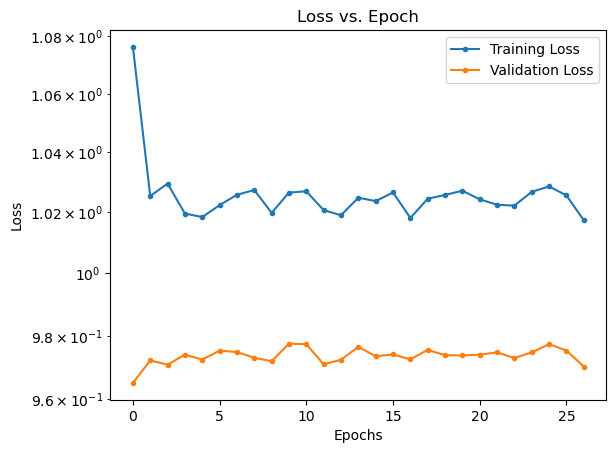

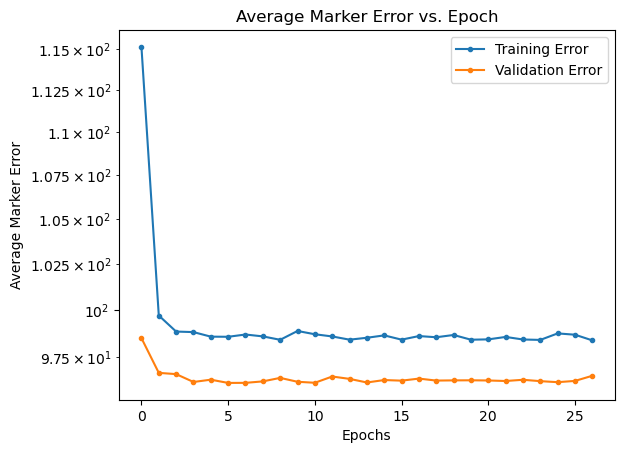

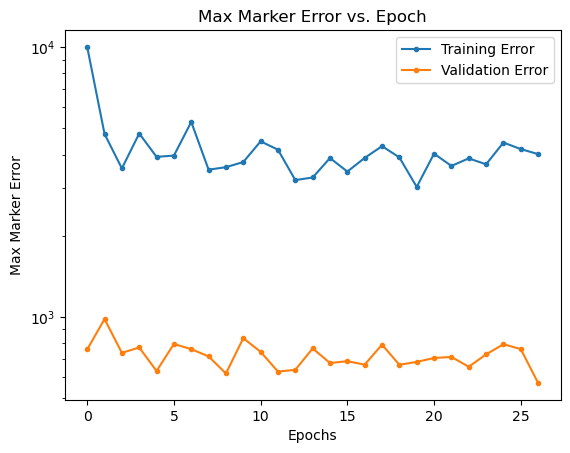

In [5]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()